In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tensorboardX import SummaryWriter

from utils import tabularModel, titanicDataset

from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune.suggest.bayesopt import BayesOptSearch

import time
%matplotlib inline

In [2]:
def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    np.random.seed(seed)
set_seed(0)

In [3]:
train_data = pd.read_csv(os.path.join('data', 'titanic', 'train.csv'))

In [4]:
train_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [11]:
def train(config):
    batch_size = int(config['batch_size'])
    num_embedding = int(config['num_embedding'])
    learning_rate = config['learning_rate']
    fc_size = (int(config['fc_size_0']), int(config['fc_size_1']))
    dropout = (config['dropout_0'], config['dropout_1'])
    if 'save' in list(config.keys()):
        writer = SummaryWriter('tmp/batchsize-{}-lr-{}-embed-{}'.format(batch_size, learning_rate, num_embedding))
    dataset = titanicDataset(os.path.join('/ldap_home', 'chang.liao', '4483A3', 'data', 'titanic', 'train.csv'))
    train_dataset, valid_dataset = torch.utils.data.random_split(dataset,
                                                                 [int(0.8 * len(dataset)),
                                                                  len(dataset) - int(0.8 * len(dataset))])
    train_dataloader = DataLoader(train_dataset,
                                  batch_size=batch_size, shuffle=True, num_workers=4)
    valid_dataloader = DataLoader(valid_dataset,
                                 batch_size=len(valid_dataset), shuffle=False, num_workers=4)
    categorical_columns = ['Pclass', 'Sex', 'Embarked', 'binned_family']
    categories = [3, 2, 3, 4]
    continuous_columns = ['Fare', 'Age']
    embedding_size = list(zip(categories, [num_embedding] * 4))
    model = tabularModel(embedding_size, categorical_columns, continuous_columns, fc_size, dropout).double()
    optim = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.95)
    lossfunc = nn.CrossEntropyLoss()
    num_epoch = 300
    best_accu = 0
    cnt = 0
    model.train()
    for epoch in range(num_epoch):
        for i, (x, y) in enumerate(train_dataloader):
            optim.zero_grad()
            pred = model(x)
            loss = lossfunc(pred, y.squeeze().long())
            loss.backward()
            optim.step()

        with torch.no_grad():
            model.eval()
            x, y = next(iter(valid_dataloader))
            pred = model(x)
            valid_loss = lossfunc(pred, y.squeeze().long())
            accu = (pred.argmax(-1) == y.squeeze()).sum().item() / len(valid_dataset)
        if 'save' in list(config.keys()):
            print("Epoch: {} | Train loss: {:.4f} | Valid loss: {:.4f} | Valid Accu: {:.4f}".format(
                epoch, loss.item(), valid_loss.item(), accu
            ))
        
            writer.add_scalars('loss', {'train loss': loss.item(),
                                    'valid loss': valid_loss.item()
                                    }, epoch * (len(train_dataset) // batch_size) + i)
            writer.add_scalar('valid accu', accu,  epoch * (len(train_dataset) // batch_size) + i)
        model.train()
        # print("\n {:.4f} {:.4f} {} \n".format(1.02 * best_accu, accu, cnt))
        if accu >= best_accu:
            cnt = 0
            best_accu = accu
            if 'save' in list(config.keys()):
                torch.save(model.state_dict(), os.path.join('model', 'titanic',
                                                        'model-{}.pt'.format(epoch)))
        else:
            cnt += 1

        if cnt == 50:
            # print("Early stopped!")
            break
    return best_accu

In [6]:
# def raytune_trainable(config, checkpoint_dir=None):
#     tune.report(accu=train(config))

In [7]:
# search_space = {
#     'batch_size': (2, 64),
#     'num_embedding': (4, 256),
#     'learning_rate': (1e-4, 0.1),
#     'fc_size_0': (64, 256),
#     'fc_size_1': (8, 128),
#     'dropout_0': (0.1, 0.8),
#     'dropout_1': (0.1, 0.8)
# }

In [10]:
# algo = BayesOptSearch(space=search_space, metric='accu', mode='max', random_search_steps=5)
# start = time.time()
# analysis = tune.run(raytune_trainable, search_alg=algo, num_samples=100, 
#                     # checkpoint_freq=4,
#                     # checkpoint_at_end=True,
#                     local_dir=os.curdir,
#                     resources_per_trial={'cpu': 18},
#                     scheduler = ASHAScheduler(
#                         metric='accu',
#                         mode='max'),
#                     raise_on_failed_trial=False
#                    )
# end = time.time()
# print(end-start)

2020-11-11 16:47:20,654	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8265
2020-11-11 16:47:22,888	WARNING tune.py:401 -- Tune detects GPUs, but no trials are using GPUs. To enable trials to use GPUs, set tune.run(resources_per_trial={'gpu': 1}...) which allows Tune to expose 1 GPU to each trial. You can also override `Trainable.default_resource_request` if using the Trainable API.
2020-11-11 16:47:22,895	INFO logger.py:201 -- pip install 'ray[tune]' to see TensorBoard files.
2020-11-11 16:47:22,896	WARNING logger.py:343 -- Could not instantiate TBXLogger: No module named 'tensorboardX'.


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding
raytune_trainable_8408eb2c,RUNNING,,25.2215,0.7655,0.612396,178.942,26.7222,0.0156839,18.6371


Result for raytune_trainable_840cd0c0:
  accu: 0.5698324022346368
  date: 2020-11-11_16-48-36
  done: false
  experiment_id: f7debc176c98470c98519ac85adf3288
  experiment_tag: 2_batch_size=55.703,dropout_0=0.52078,dropout_1=0.59565,fc_size_0=67.952,fc_size_1=124.39,learning_rate=0.083261,num_embedding=57.509
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55197
  time_since_restore: 72.78842234611511
  time_this_iter_s: 72.78842234611511
  time_total_s: 72.78842234611511
  timestamp: 1605084516
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 840cd0c0
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_8408eb2c,RUNNING,,25.2215,0.7655,0.612396,178.942,26.7222,0.0156839,18.6371,,,
raytune_trainable_840cd0c0,RUNNING,10.128.148.194:55197,55.7029,0.520781,0.595651,67.9522,124.389,0.083261,57.5095,1,72.7884,0.569832
raytune_trainable_840ddefc,RUNNING,,13.2731,0.228383,0.31297,164.753,59.8334,0.0291938,158.187,,,
raytune_trainable_840ee554,PENDING,,10.6486,0.304501,0.356453,151.565,102.221,0.0200474,133.587,,,


Result for raytune_trainable_8408eb2c:
  accu: 0.6201117318435754
  date: 2020-11-11_16-49-21
  done: false
  experiment_id: 076ccc0ea91f4db7a0792935f5da1571
  experiment_tag: 1_batch_size=25.221,dropout_0=0.7655,dropout_1=0.6124,fc_size_0=178.94,fc_size_1=26.722,learning_rate=0.015684,num_embedding=18.637
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55187
  time_since_restore: 118.1078028678894
  time_this_iter_s: 118.1078028678894
  time_total_s: 118.1078028678894
  timestamp: 1605084561
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 8408eb2c
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_8408eb2c,RUNNING,10.128.148.194:55187,25.2215,0.7655,0.612396,178.942,26.7222,0.0156839,18.6371,1,118.108,0.620112
raytune_trainable_840ddefc,RUNNING,,13.2731,0.228383,0.31297,164.753,59.8334,0.0291938,158.187,,,
raytune_trainable_840ee554,RUNNING,,10.6486,0.304501,0.356453,151.565,102.221,0.0200474,133.587,,,
raytune_trainable_afeecf36,PENDING,,38.7297,0.132515,0.525281,96.7406,15.8062,0.0948937,247.339,,,
raytune_trainable_840cd0c0,TERMINATED,,55.7029,0.520781,0.595651,67.9522,124.389,0.083261,57.5095,1,72.7884,0.569832


Result for raytune_trainable_840ee554:
  accu: 0.7039106145251397
  date: 2020-11-11_16-49-29
  done: false
  experiment_id: 39dbf389b14e4f999d81707ce06db86d
  experiment_tag: 4_batch_size=10.649,dropout_0=0.3045,dropout_1=0.35645,fc_size_0=151.57,fc_size_1=102.22,learning_rate=0.020047,num_embedding=133.59
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55176
  time_since_restore: 51.81317901611328
  time_this_iter_s: 51.81317901611328
  time_total_s: 51.81317901611328
  timestamp: 1605084569
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 840ee554
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_840ddefc,RUNNING,,13.2731,0.228383,0.31297,164.753,59.8334,0.0291938,158.187,,,
raytune_trainable_840ee554,RUNNING,10.128.148.194:55176,10.6486,0.304501,0.356453,151.565,102.221,0.0200474,133.587,1,51.8132,0.703911
raytune_trainable_afeecf36,RUNNING,,38.7297,0.132515,0.525281,96.7406,15.8062,0.0948937,247.339,,,
raytune_trainable_8408eb2c,TERMINATED,,25.2215,0.7655,0.612396,178.942,26.7222,0.0156839,18.6371,1,118.108,0.620112
raytune_trainable_840cd0c0,TERMINATED,,55.7029,0.520781,0.595651,67.9522,124.389,0.083261,57.5095,1,72.7884,0.569832


Result for raytune_trainable_afeecf36:
  accu: 0.6256983240223464
  date: 2020-11-11_16-51-24
  done: true
  experiment_id: c45dd953ce0e4e57aeaaada278d25d0d
  experiment_tag: 5_batch_size=38.73,dropout_0=0.13252,dropout_1=0.52528,fc_size_0=96.741,fc_size_1=15.806,learning_rate=0.094894,num_embedding=247.34
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55154
  time_since_restore: 121.80044960975647
  time_this_iter_s: 121.80044960975647
  time_total_s: 121.80044960975647
  timestamp: 1605084684
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: afeecf36
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_840ddefc,RUNNING,,13.2731,0.228383,0.31297,164.753,59.8334,0.0291938,158.187,,,
raytune_trainable_8408eb2c,TERMINATED,,25.2215,0.7655,0.612396,178.942,26.7222,0.0156839,18.6371,1,118.108,0.620112
raytune_trainable_840cd0c0,TERMINATED,,55.7029,0.520781,0.595651,67.9522,124.389,0.083261,57.5095,1,72.7884,0.569832
raytune_trainable_840ee554,TERMINATED,,10.6486,0.304501,0.356453,151.565,102.221,0.0200474,133.587,1,51.8132,0.703911
raytune_trainable_afeecf36,TERMINATED,,38.7297,0.132515,0.525281,96.7406,15.8062,0.0948937,247.339,1,121.8,0.625698


Result for raytune_trainable_840ddefc:
  accu: 0.5921787709497207
  date: 2020-11-11_16-51-47
  done: true
  experiment_id: ac301d922db24933b436adfbd51e175d
  experiment_tag: 3_batch_size=13.273,dropout_0=0.22838,dropout_1=0.31297,fc_size_0=164.75,fc_size_1=59.833,learning_rate=0.029194,num_embedding=158.19
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55174
  time_since_restore: 263.82481837272644
  time_this_iter_s: 263.82481837272644
  time_total_s: 263.82481837272644
  timestamp: 1605084707
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 840ddefc
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_8408eb2c,TERMINATED,,25.2215,0.7655,0.612396,178.942,26.7222,0.0156839,18.6371,1,118.108,0.620112
raytune_trainable_840cd0c0,TERMINATED,,55.7029,0.520781,0.595651,67.9522,124.389,0.083261,57.5095,1,72.7884,0.569832
raytune_trainable_840ddefc,TERMINATED,,13.2731,0.228383,0.31297,164.753,59.8334,0.0291938,158.187,1,263.825,0.592179
raytune_trainable_840ee554,TERMINATED,,10.6486,0.304501,0.356453,151.565,102.221,0.0200474,133.587,1,51.8132,0.703911
raytune_trainable_afeecf36,TERMINATED,,38.7297,0.132515,0.525281,96.7406,15.8062,0.0948937,247.339,1,121.8,0.625698


Result for raytune_trainable_21d5d496:
  accu: 0.7932960893854749
  date: 2020-11-11_16-52-09
  done: false
  experiment_id: 8a0f036722944fe3a0db2abf813f9f69
  experiment_tag: 7_batch_size=35.219,dropout_0=0.39328,dropout_1=0.45974,fc_size_0=91.648,fc_size_1=12.859,learning_rate=0.0064104,num_embedding=249.15
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55194
  time_since_restore: 21.32636022567749
  time_this_iter_s: 21.32636022567749
  time_total_s: 21.32636022567749
  timestamp: 1605084729
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 21d5d496
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_21cd3fca,RUNNING,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,,,
raytune_trainable_21d5d496,RUNNING,10.128.148.194:55194,35.2193,0.393282,0.459743,91.6478,12.8588,0.00641037,249.152,1,21.3264,0.793296
raytune_trainable_21dc1de2,RUNNING,,5.88289,0.790241,0.427749,160.339,103.568,0.046476,131.438,,,
raytune_trainable_21e2bbf2,PENDING,,36.1205,0.389657,0.731134,101.514,14.312,0.0475347,241.336,,,
raytune_trainable_8408eb2c,TERMINATED,,25.2215,0.7655,0.612396,178.942,26.7222,0.0156839,18.6371,1,118.108,0.620112
raytune_trainable_840cd0c0,TERMINATED,,55.7029,0.520781,0.595651,67.9522,124.389,0.083261,57.5095,1,72.7884,0.569832
raytune_trainable_840ddefc,TERMINATED,,13.2731,0.228383,0.31297,164.753,59.8334,0.0291938,158.187,1,263.825,0.592179
raytune_trainable_840ee554,TERMINATED,,10.6486,0.304501,0.356453,151.565,102.221,0.0200474,133.587,1,51.8132,0.703911
raytune_trainable_afeecf36,TERMINATED,,38.7297,0.132515,0.525281,96.7406,15.8062,0.0948937,247.339,1,121.8,0.625698


Result for raytune_trainable_21e2bbf2:
  accu: 0.6983240223463687
  date: 2020-11-11_16-52-25
  done: false
  experiment_id: 13f8668411844eb09988e0a9cb972be5
  experiment_tag: 9_batch_size=36.12,dropout_0=0.38966,dropout_1=0.73113,fc_size_0=101.51,fc_size_1=14.312,learning_rate=0.047535,num_embedding=241.34
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55183
  time_since_restore: 14.829602241516113
  time_this_iter_s: 14.829602241516113
  time_total_s: 14.829602241516113
  timestamp: 1605084745
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 21e2bbf2
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_21cd3fca,RUNNING,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,,,
raytune_trainable_21dc1de2,RUNNING,,5.88289,0.790241,0.427749,160.339,103.568,0.046476,131.438,,,
raytune_trainable_21e2bbf2,RUNNING,10.128.148.194:55183,36.1205,0.389657,0.731134,101.514,14.312,0.0475347,241.336,1,14.8296,0.698324
raytune_trainable_2f20b51c,PENDING,,36.4767,0.732621,0.563282,108.258,123.934,0.039675,10.9711,,,
raytune_trainable_8408eb2c,TERMINATED,,25.2215,0.7655,0.612396,178.942,26.7222,0.0156839,18.6371,1,118.108,0.620112
raytune_trainable_840cd0c0,TERMINATED,,55.7029,0.520781,0.595651,67.9522,124.389,0.083261,57.5095,1,72.7884,0.569832
raytune_trainable_840ddefc,TERMINATED,,13.2731,0.228383,0.31297,164.753,59.8334,0.0291938,158.187,1,263.825,0.592179
raytune_trainable_840ee554,TERMINATED,,10.6486,0.304501,0.356453,151.565,102.221,0.0200474,133.587,1,51.8132,0.703911
raytune_trainable_afeecf36,TERMINATED,,38.7297,0.132515,0.525281,96.7406,15.8062,0.0948937,247.339,1,121.8,0.625698
raytune_trainable_21d5d496,TERMINATED,,35.2193,0.393282,0.459743,91.6478,12.8588,0.00641037,249.152,1,21.3264,0.793296


Result for raytune_trainable_2f20b51c:
  accu: 0.6201117318435754
  date: 2020-11-11_16-53-50
  done: true
  experiment_id: 582c3b8a20ef4b81a71c237b53131507
  experiment_tag: 10_batch_size=36.477,dropout_0=0.73262,dropout_1=0.56328,fc_size_0=108.26,fc_size_1=123.93,learning_rate=0.039675,num_embedding=10.971
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55185
  time_since_restore: 83.76984143257141
  time_this_iter_s: 83.76984143257141
  time_total_s: 83.76984143257141
  timestamp: 1605084830
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2f20b51c
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_21cd3fca,RUNNING,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,,,
raytune_trainable_21dc1de2,RUNNING,,5.88289,0.790241,0.427749,160.339,103.568,0.046476,131.438,,,
raytune_trainable_3887c500,PENDING,,52.1662,0.234922,0.695573,188.987,87.5686,0.00521468,109.533,,,
raytune_trainable_8408eb2c,TERMINATED,,25.2215,0.7655,0.612396,178.942,26.7222,0.0156839,18.6371,1,118.108,0.620112
raytune_trainable_840cd0c0,TERMINATED,,55.7029,0.520781,0.595651,67.9522,124.389,0.083261,57.5095,1,72.7884,0.569832
raytune_trainable_840ddefc,TERMINATED,,13.2731,0.228383,0.31297,164.753,59.8334,0.0291938,158.187,1,263.825,0.592179
raytune_trainable_840ee554,TERMINATED,,10.6486,0.304501,0.356453,151.565,102.221,0.0200474,133.587,1,51.8132,0.703911
raytune_trainable_afeecf36,TERMINATED,,38.7297,0.132515,0.525281,96.7406,15.8062,0.0948937,247.339,1,121.8,0.625698
raytune_trainable_21d5d496,TERMINATED,,35.2193,0.393282,0.459743,91.6478,12.8588,0.00641037,249.152,1,21.3264,0.793296
raytune_trainable_21e2bbf2,TERMINATED,,36.1205,0.389657,0.731134,101.514,14.312,0.0475347,241.336,1,14.8296,0.698324


Result for raytune_trainable_3887c500:
  accu: 0.770949720670391
  date: 2020-11-11_16-54-10
  done: false
  experiment_id: 0452f5ba436f48639c04483f91ad7360
  experiment_tag: 11_batch_size=52.166,dropout_0=0.23492,dropout_1=0.69557,fc_size_0=188.99,fc_size_1=87.569,learning_rate=0.0052147,num_embedding=109.53
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55170
  time_since_restore: 19.38624858856201
  time_this_iter_s: 19.38624858856201
  time_total_s: 19.38624858856201
  timestamp: 1605084850
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 3887c500
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_21cd3fca,RUNNING,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,,,
raytune_trainable_21dc1de2,RUNNING,,5.88289,0.790241,0.427749,160.339,103.568,0.046476,131.438,,,
raytune_trainable_3887c500,RUNNING,10.128.148.194:55170,52.1662,0.234922,0.695573,188.987,87.5686,0.00521468,109.533,1,19.3862,0.77095
raytune_trainable_6b0d008a,PENDING,,45.9994,0.542047,0.661234,193.392,109.373,0.0216381,245.921,,,
raytune_trainable_8408eb2c,TERMINATED,,25.2215,0.7655,0.612396,178.942,26.7222,0.0156839,18.6371,1,118.108,0.620112
raytune_trainable_840cd0c0,TERMINATED,,55.7029,0.520781,0.595651,67.9522,124.389,0.083261,57.5095,1,72.7884,0.569832
raytune_trainable_840ddefc,TERMINATED,,13.2731,0.228383,0.31297,164.753,59.8334,0.0291938,158.187,1,263.825,0.592179
raytune_trainable_840ee554,TERMINATED,,10.6486,0.304501,0.356453,151.565,102.221,0.0200474,133.587,1,51.8132,0.703911
raytune_trainable_afeecf36,TERMINATED,,38.7297,0.132515,0.525281,96.7406,15.8062,0.0948937,247.339,1,121.8,0.625698
raytune_trainable_21d5d496,TERMINATED,,35.2193,0.393282,0.459743,91.6478,12.8588,0.00641037,249.152,1,21.3264,0.793296


Result for raytune_trainable_6b0d008a:
  accu: 0.7877094972067039
  date: 2020-11-11_16-54-28
  done: false
  experiment_id: 41d14955d13d4e14a72aee97a167362c
  experiment_tag: 12_batch_size=45.999,dropout_0=0.54205,dropout_1=0.66123,fc_size_0=193.39,fc_size_1=109.37,learning_rate=0.021638,num_embedding=245.92
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55199
  time_since_restore: 16.86827850341797
  time_this_iter_s: 16.86827850341797
  time_total_s: 16.86827850341797
  timestamp: 1605084868
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6b0d008a
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_21cd3fca,RUNNING,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,,,
raytune_trainable_21dc1de2,RUNNING,,5.88289,0.790241,0.427749,160.339,103.568,0.046476,131.438,,,
raytune_trainable_6b0d008a,RUNNING,10.128.148.194:55199,45.9994,0.542047,0.661234,193.392,109.373,0.0216381,245.921,1,16.8683,0.787709
raytune_trainable_772c6608,PENDING,,9.38476,0.765226,0.777863,247.036,118.983,0.0237207,110.198,,,
raytune_trainable_8408eb2c,TERMINATED,,25.2215,0.7655,0.612396,178.942,26.7222,0.0156839,18.6371,1,118.108,0.620112
raytune_trainable_840cd0c0,TERMINATED,,55.7029,0.520781,0.595651,67.9522,124.389,0.083261,57.5095,1,72.7884,0.569832
raytune_trainable_840ddefc,TERMINATED,,13.2731,0.228383,0.31297,164.753,59.8334,0.0291938,158.187,1,263.825,0.592179
raytune_trainable_840ee554,TERMINATED,,10.6486,0.304501,0.356453,151.565,102.221,0.0200474,133.587,1,51.8132,0.703911
raytune_trainable_afeecf36,TERMINATED,,38.7297,0.132515,0.525281,96.7406,15.8062,0.0948937,247.339,1,121.8,0.625698
raytune_trainable_21d5d496,TERMINATED,,35.2193,0.393282,0.459743,91.6478,12.8588,0.00641037,249.152,1,21.3264,0.793296


(pid=55172) 2020-11-11 16:54:30,740	ERROR function_runner.py:254 -- Runner Thread raised error.
(pid=55172) Traceback (most recent call last):
(pid=55172)   File "/ldap_home/chang.liao/anaconda3/envs/AAA/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=55172)     self._entrypoint()
(pid=55172)   File "/ldap_home/chang.liao/anaconda3/envs/AAA/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=55172)     self._status_reporter.get_checkpoint())
(pid=55172)   File "/ldap_home/chang.liao/anaconda3/envs/AAA/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=55172)     output = fn()
(pid=55172)   File "<ipython-input-8-4ea6617a47e8>", line 2, in raytune_trainable
(pid=55172)   File "<ipython-input-7-3e4d2d2dc1be>", line 29, in train
(pid=55172)   File "/ldap_home/chang.liao/anaconda3/envs/AAA/lib/python3.6/site-packages/torch/nn/modules/module.py", line 532, in __call__
(pid=55172)     

Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_21cd3fca,RUNNING,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,,,
raytune_trainable_21dc1de2,RUNNING,,5.88289,0.790241,0.427749,160.339,103.568,0.046476,131.438,,,
raytune_trainable_8324d530,PENDING,,28.5543,0.329077,0.462262,252.435,10.0205,0.0890689,134.9,,,
raytune_trainable_8408eb2c,TERMINATED,,25.2215,0.7655,0.612396,178.942,26.7222,0.0156839,18.6371,1,118.108,0.620112
raytune_trainable_840cd0c0,TERMINATED,,55.7029,0.520781,0.595651,67.9522,124.389,0.083261,57.5095,1,72.7884,0.569832
raytune_trainable_840ddefc,TERMINATED,,13.2731,0.228383,0.31297,164.753,59.8334,0.0291938,158.187,1,263.825,0.592179
raytune_trainable_840ee554,TERMINATED,,10.6486,0.304501,0.356453,151.565,102.221,0.0200474,133.587,1,51.8132,0.703911
raytune_trainable_afeecf36,TERMINATED,,38.7297,0.132515,0.525281,96.7406,15.8062,0.0948937,247.339,1,121.8,0.625698
raytune_trainable_21d5d496,TERMINATED,,35.2193,0.393282,0.459743,91.6478,12.8588,0.00641037,249.152,1,21.3264,0.793296
raytune_trainable_21e2bbf2,TERMINATED,,36.1205,0.389657,0.731134,101.514,14.312,0.0475347,241.336,1,14.8296,0.698324


Result for raytune_trainable_21cd3fca:
  accu: 0.6201117318435754
  date: 2020-11-11_16-56-50
  done: true
  experiment_id: 63f5fc901e534c10b9536eaa8baaccdf
  experiment_tag: 6_batch_size=11.392,dropout_0=0.3692,dropout_1=0.13024,fc_size_0=154.1,fc_size_1=98.37,learning_rate=0.079018,num_embedding=129.75
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55212
  time_since_restore: 302.1715319156647
  time_this_iter_s: 302.1715319156647
  time_total_s: 302.1715319156647
  timestamp: 1605085010
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 21cd3fca
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_21dc1de2,RUNNING,,5.88289,0.790241,0.427749,160.339,103.568,0.046476,131.438,,,
raytune_trainable_8324d530,RUNNING,,28.5543,0.329077,0.462262,252.435,10.0205,0.0890689,134.9,,,
raytune_trainable_8b6571b4,PENDING,,2.40139,0.438061,0.303606,176.577,69.3085,0.0160541,247.543,,,
raytune_trainable_8408eb2c,TERMINATED,,25.2215,0.7655,0.612396,178.942,26.7222,0.0156839,18.6371,1,118.108,0.620112
raytune_trainable_840cd0c0,TERMINATED,,55.7029,0.520781,0.595651,67.9522,124.389,0.083261,57.5095,1,72.7884,0.569832
raytune_trainable_840ddefc,TERMINATED,,13.2731,0.228383,0.31297,164.753,59.8334,0.0291938,158.187,1,263.825,0.592179
raytune_trainable_840ee554,TERMINATED,,10.6486,0.304501,0.356453,151.565,102.221,0.0200474,133.587,1,51.8132,0.703911
raytune_trainable_afeecf36,TERMINATED,,38.7297,0.132515,0.525281,96.7406,15.8062,0.0948937,247.339,1,121.8,0.625698
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112
raytune_trainable_21d5d496,TERMINATED,,35.2193,0.393282,0.459743,91.6478,12.8588,0.00641037,249.152,1,21.3264,0.793296


Result for raytune_trainable_8324d530:
  accu: 0.664804469273743
  date: 2020-11-11_16-57-09
  done: true
  experiment_id: 4be0b9056c044691ac4bd6dd876875be
  experiment_tag: 15_batch_size=28.554,dropout_0=0.32908,dropout_1=0.46226,fc_size_0=252.44,fc_size_1=10.02,learning_rate=0.089069,num_embedding=134.9
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55169
  time_since_restore: 144.34275221824646
  time_this_iter_s: 144.34275221824646
  time_total_s: 144.34275221824646
  timestamp: 1605085029
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 8324d530
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_21dc1de2,RUNNING,,5.88289,0.790241,0.427749,160.339,103.568,0.046476,131.438,,,
raytune_trainable_8b6571b4,RUNNING,,2.40139,0.438061,0.303606,176.577,69.3085,0.0160541,247.543,,,
raytune_trainable_d67ead78,PENDING,,50.2173,0.600026,0.518961,68.9917,61.0542,0.0569831,174.284,,,
raytune_trainable_8408eb2c,TERMINATED,,25.2215,0.7655,0.612396,178.942,26.7222,0.0156839,18.6371,1,118.108,0.620112
raytune_trainable_840cd0c0,TERMINATED,,55.7029,0.520781,0.595651,67.9522,124.389,0.083261,57.5095,1,72.7884,0.569832
raytune_trainable_840ddefc,TERMINATED,,13.2731,0.228383,0.31297,164.753,59.8334,0.0291938,158.187,1,263.825,0.592179
raytune_trainable_840ee554,TERMINATED,,10.6486,0.304501,0.356453,151.565,102.221,0.0200474,133.587,1,51.8132,0.703911
raytune_trainable_afeecf36,TERMINATED,,38.7297,0.132515,0.525281,96.7406,15.8062,0.0948937,247.339,1,121.8,0.625698
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112
raytune_trainable_21d5d496,TERMINATED,,35.2193,0.393282,0.459743,91.6478,12.8588,0.00641037,249.152,1,21.3264,0.793296


Result for raytune_trainable_d67ead78:
  accu: 0.6201117318435754
  date: 2020-11-11_16-59-03
  done: true
  experiment_id: fb19963942fe4f7c890fcb48ee520e94
  experiment_tag: 17_batch_size=50.217,dropout_0=0.60003,dropout_1=0.51896,fc_size_0=68.992,fc_size_1=61.054,learning_rate=0.056983,num_embedding=174.28
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55146
  time_since_restore: 112.49581456184387
  time_this_iter_s: 112.49581456184387
  time_total_s: 112.49581456184387
  timestamp: 1605085143
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d67ead78
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_21dc1de2,RUNNING,,5.88289,0.790241,0.427749,160.339,103.568,0.046476,131.438,,,
raytune_trainable_8b6571b4,RUNNING,,2.40139,0.438061,0.303606,176.577,69.3085,0.0160541,247.543,,,
raytune_trainable_e1ffbcd2,PENDING,,22.9123,0.776102,0.166215,154.538,124.744,0.0583025,201.204,,,
raytune_trainable_8408eb2c,TERMINATED,,25.2215,0.7655,0.612396,178.942,26.7222,0.0156839,18.6371,1,118.108,0.620112
raytune_trainable_840cd0c0,TERMINATED,,55.7029,0.520781,0.595651,67.9522,124.389,0.083261,57.5095,1,72.7884,0.569832
raytune_trainable_840ddefc,TERMINATED,,13.2731,0.228383,0.31297,164.753,59.8334,0.0291938,158.187,1,263.825,0.592179
raytune_trainable_840ee554,TERMINATED,,10.6486,0.304501,0.356453,151.565,102.221,0.0200474,133.587,1,51.8132,0.703911
raytune_trainable_afeecf36,TERMINATED,,38.7297,0.132515,0.525281,96.7406,15.8062,0.0948937,247.339,1,121.8,0.625698
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112
raytune_trainable_21d5d496,TERMINATED,,35.2193,0.393282,0.459743,91.6478,12.8588,0.00641037,249.152,1,21.3264,0.793296


Result for raytune_trainable_e1ffbcd2:
  accu: 0.6759776536312849
  date: 2020-11-11_17-02-14
  done: true
  experiment_id: 9bad4f9b10164c69ad77fffe02baace3
  experiment_tag: 18_batch_size=22.912,dropout_0=0.7761,dropout_1=0.16621,fc_size_0=154.54,fc_size_1=124.74,learning_rate=0.058303,num_embedding=201.2
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55204
  time_since_restore: 189.9363775253296
  time_this_iter_s: 189.9363775253296
  time_total_s: 189.9363775253296
  timestamp: 1605085334
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e1ffbcd2
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_21dc1de2,RUNNING,,5.88289,0.790241,0.427749,160.339,103.568,0.046476,131.438,,,
raytune_trainable_8b6571b4,RUNNING,,2.40139,0.438061,0.303606,176.577,69.3085,0.0160541,247.543,,,
raytune_trainable_259ebcb8,PENDING,,32.6393,0.665141,0.485209,246.921,64.5616,0.0940617,83.3017,,,
raytune_trainable_8408eb2c,TERMINATED,,25.2215,0.7655,0.612396,178.942,26.7222,0.0156839,18.6371,1,118.108,0.620112
raytune_trainable_840cd0c0,TERMINATED,,55.7029,0.520781,0.595651,67.9522,124.389,0.083261,57.5095,1,72.7884,0.569832
raytune_trainable_840ddefc,TERMINATED,,13.2731,0.228383,0.31297,164.753,59.8334,0.0291938,158.187,1,263.825,0.592179
raytune_trainable_840ee554,TERMINATED,,10.6486,0.304501,0.356453,151.565,102.221,0.0200474,133.587,1,51.8132,0.703911
raytune_trainable_afeecf36,TERMINATED,,38.7297,0.132515,0.525281,96.7406,15.8062,0.0948937,247.339,1,121.8,0.625698
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112
raytune_trainable_21d5d496,TERMINATED,,35.2193,0.393282,0.459743,91.6478,12.8588,0.00641037,249.152,1,21.3264,0.793296


Result for raytune_trainable_21dc1de2:
  accu: 0.6871508379888268
  date: 2020-11-11_17-02-36
  done: true
  experiment_id: 773feff9cf4543ff80098d61294c6062
  experiment_tag: 8_batch_size=5.8829,dropout_0=0.79024,dropout_1=0.42775,fc_size_0=160.34,fc_size_1=103.57,learning_rate=0.046476,num_embedding=131.44
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55184
  time_since_restore: 648.148402929306
  time_this_iter_s: 648.148402929306
  time_total_s: 648.148402929306
  timestamp: 1605085356
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 21dc1de2
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_8b6571b4,RUNNING,,2.40139,0.438061,0.303606,176.577,69.3085,0.0160541,247.543,,,
raytune_trainable_259ebcb8,RUNNING,,32.6393,0.665141,0.485209,246.921,64.5616,0.0940617,83.3017,,,
raytune_trainable_9778b906,PENDING,,48.2759,0.336926,0.417293,189.944,83.0977,0.0205909,192.351,,,
raytune_trainable_8408eb2c,TERMINATED,,25.2215,0.7655,0.612396,178.942,26.7222,0.0156839,18.6371,1,118.108,0.620112
raytune_trainable_840cd0c0,TERMINATED,,55.7029,0.520781,0.595651,67.9522,124.389,0.083261,57.5095,1,72.7884,0.569832
raytune_trainable_840ddefc,TERMINATED,,13.2731,0.228383,0.31297,164.753,59.8334,0.0291938,158.187,1,263.825,0.592179
raytune_trainable_840ee554,TERMINATED,,10.6486,0.304501,0.356453,151.565,102.221,0.0200474,133.587,1,51.8132,0.703911
raytune_trainable_afeecf36,TERMINATED,,38.7297,0.132515,0.525281,96.7406,15.8062,0.0948937,247.339,1,121.8,0.625698
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112
raytune_trainable_21d5d496,TERMINATED,,35.2193,0.393282,0.459743,91.6478,12.8588,0.00641037,249.152,1,21.3264,0.793296


Result for raytune_trainable_9778b906:
  accu: 0.8268156424581006
  date: 2020-11-11_17-02-53
  done: false
  experiment_id: 5fb731f7354d43cdab7c0254e188cee3
  experiment_tag: 20_batch_size=48.276,dropout_0=0.33693,dropout_1=0.41729,fc_size_0=189.94,fc_size_1=83.098,learning_rate=0.020591,num_embedding=192.35
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55192
  time_since_restore: 15.52371335029602
  time_this_iter_s: 15.52371335029602
  time_total_s: 15.52371335029602
  timestamp: 1605085373
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9778b906
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_259ebcb8,RUNNING,,32.6393,0.665141,0.485209,246.921,64.5616,0.0940617,83.3017,,,
raytune_trainable_8b6571b4,RUNNING,,2.40139,0.438061,0.303606,176.577,69.3085,0.0160541,247.543,,,
raytune_trainable_9778b906,RUNNING,10.128.148.194:55192,48.2759,0.336926,0.417293,189.944,83.0977,0.0205909,192.351,1,15.5237,0.826816
raytune_trainable_a4bfd90a,PENDING,,60.1868,0.653499,0.277942,197.454,34.5049,0.0648867,189.63,,,
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112
raytune_trainable_21d5d496,TERMINATED,,35.2193,0.393282,0.459743,91.6478,12.8588,0.00641037,249.152,1,21.3264,0.793296
raytune_trainable_21dc1de2,TERMINATED,,5.88289,0.790241,0.427749,160.339,103.568,0.046476,131.438,1,648.148,0.687151
raytune_trainable_21e2bbf2,TERMINATED,,36.1205,0.389657,0.731134,101.514,14.312,0.0475347,241.336,1,14.8296,0.698324
raytune_trainable_2f20b51c,TERMINATED,,36.4767,0.732621,0.563282,108.258,123.934,0.039675,10.9711,1,83.7698,0.620112
raytune_trainable_3887c500,TERMINATED,,52.1662,0.234922,0.695573,188.987,87.5686,0.00521468,109.533,1,19.3862,0.77095


Result for raytune_trainable_a4bfd90a:
  accu: 0.6927374301675978
  date: 2020-11-11_17-03-07
  done: true
  experiment_id: e85ad516e7824fdf9e809fa7f706de33
  experiment_tag: 21_batch_size=60.187,dropout_0=0.6535,dropout_1=0.27794,fc_size_0=197.45,fc_size_1=34.505,learning_rate=0.064887,num_embedding=189.63
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55171
  time_since_restore: 13.767361164093018
  time_this_iter_s: 13.767361164093018
  time_total_s: 13.767361164093018
  timestamp: 1605085387
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a4bfd90a
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_259ebcb8,RUNNING,,32.6393,0.665141,0.485209,246.921,64.5616,0.0940617,83.3017,,,
raytune_trainable_8b6571b4,RUNNING,,2.40139,0.438061,0.303606,176.577,69.3085,0.0160541,247.543,,,
raytune_trainable_ae8bb88c,PENDING,,43.7219,0.447767,0.48742,115.739,58.4915,0.0245692,253.772,,,
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112
raytune_trainable_21d5d496,TERMINATED,,35.2193,0.393282,0.459743,91.6478,12.8588,0.00641037,249.152,1,21.3264,0.793296
raytune_trainable_21dc1de2,TERMINATED,,5.88289,0.790241,0.427749,160.339,103.568,0.046476,131.438,1,648.148,0.687151
raytune_trainable_21e2bbf2,TERMINATED,,36.1205,0.389657,0.731134,101.514,14.312,0.0475347,241.336,1,14.8296,0.698324
raytune_trainable_2f20b51c,TERMINATED,,36.4767,0.732621,0.563282,108.258,123.934,0.039675,10.9711,1,83.7698,0.620112
raytune_trainable_3887c500,TERMINATED,,52.1662,0.234922,0.695573,188.987,87.5686,0.00521468,109.533,1,19.3862,0.77095
raytune_trainable_6b0d008a,TERMINATED,,45.9994,0.542047,0.661234,193.392,109.373,0.0216381,245.921,1,16.8683,0.787709


Result for raytune_trainable_ae8bb88c:
  accu: 0.8379888268156425
  date: 2020-11-11_17-03-24
  done: false
  experiment_id: 8d6d6c10799b4616bd4528f95fb75d92
  experiment_tag: 22_batch_size=43.722,dropout_0=0.44777,dropout_1=0.48742,fc_size_0=115.74,fc_size_1=58.492,learning_rate=0.024569,num_embedding=253.77
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55208
  time_since_restore: 15.517733097076416
  time_this_iter_s: 15.517733097076416
  time_total_s: 15.517733097076416
  timestamp: 1605085404
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: ae8bb88c
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_259ebcb8,RUNNING,,32.6393,0.665141,0.485209,246.921,64.5616,0.0940617,83.3017,,,
raytune_trainable_8b6571b4,RUNNING,,2.40139,0.438061,0.303606,176.577,69.3085,0.0160541,247.543,,,
raytune_trainable_ae8bb88c,RUNNING,10.128.148.194:55208,43.7219,0.447767,0.48742,115.739,58.4915,0.0245692,253.772,1,15.5177,0.837989
raytune_trainable_b7561034,PENDING,,34.9935,0.622261,0.46009,150.768,75.8097,0.040714,6.74142,,,
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112
raytune_trainable_21d5d496,TERMINATED,,35.2193,0.393282,0.459743,91.6478,12.8588,0.00641037,249.152,1,21.3264,0.793296
raytune_trainable_21dc1de2,TERMINATED,,5.88289,0.790241,0.427749,160.339,103.568,0.046476,131.438,1,648.148,0.687151
raytune_trainable_21e2bbf2,TERMINATED,,36.1205,0.389657,0.731134,101.514,14.312,0.0475347,241.336,1,14.8296,0.698324
raytune_trainable_2f20b51c,TERMINATED,,36.4767,0.732621,0.563282,108.258,123.934,0.039675,10.9711,1,83.7698,0.620112
raytune_trainable_3887c500,TERMINATED,,52.1662,0.234922,0.695573,188.987,87.5686,0.00521468,109.533,1,19.3862,0.77095


Result for raytune_trainable_259ebcb8:
  accu: 0.6201117318435754
  date: 2020-11-11_17-04-27
  done: true
  experiment_id: 94c61c8e14b243b4b59eb483c0dacbe4
  experiment_tag: 19_batch_size=32.639,dropout_0=0.66514,dropout_1=0.48521,fc_size_0=246.92,fc_size_1=64.562,learning_rate=0.094062,num_embedding=83.302
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55180
  time_since_restore: 131.63788390159607
  time_this_iter_s: 131.63788390159607
  time_total_s: 131.63788390159607
  timestamp: 1605085467
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 259ebcb8
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_8b6571b4,RUNNING,,2.40139,0.438061,0.303606,176.577,69.3085,0.0160541,247.543,,,
raytune_trainable_b7561034,RUNNING,,34.9935,0.622261,0.46009,150.768,75.8097,0.040714,6.74142,,,
raytune_trainable_c1247074,PENDING,,53.951,0.514869,0.361842,117.466,126.327,0.0418294,194.019,,,
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112
raytune_trainable_21d5d496,TERMINATED,,35.2193,0.393282,0.459743,91.6478,12.8588,0.00641037,249.152,1,21.3264,0.793296
raytune_trainable_21dc1de2,TERMINATED,,5.88289,0.790241,0.427749,160.339,103.568,0.046476,131.438,1,648.148,0.687151
raytune_trainable_21e2bbf2,TERMINATED,,36.1205,0.389657,0.731134,101.514,14.312,0.0475347,241.336,1,14.8296,0.698324
raytune_trainable_259ebcb8,TERMINATED,,32.6393,0.665141,0.485209,246.921,64.5616,0.0940617,83.3017,1,131.638,0.620112
raytune_trainable_2f20b51c,TERMINATED,,36.4767,0.732621,0.563282,108.258,123.934,0.039675,10.9711,1,83.7698,0.620112
raytune_trainable_3887c500,TERMINATED,,52.1662,0.234922,0.695573,188.987,87.5686,0.00521468,109.533,1,19.3862,0.77095


Result for raytune_trainable_c1247074:
  accu: 0.6368715083798883
  date: 2020-11-11_17-04-42
  done: true
  experiment_id: 092d96076fed43369f632b716828b8b2
  experiment_tag: 24_batch_size=53.951,dropout_0=0.51487,dropout_1=0.36184,fc_size_0=117.47,fc_size_1=126.33,learning_rate=0.041829,num_embedding=194.02
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55178
  time_since_restore: 14.287449836730957
  time_this_iter_s: 14.287449836730957
  time_total_s: 14.287449836730957
  timestamp: 1605085482
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c1247074
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_8b6571b4,RUNNING,,2.40139,0.438061,0.303606,176.577,69.3085,0.0160541,247.543,,,
raytune_trainable_b7561034,RUNNING,,34.9935,0.622261,0.46009,150.768,75.8097,0.040714,6.74142,,,
raytune_trainable_e68d3652,PENDING,,22.4008,0.606437,0.340022,180.998,97.0705,0.00238762,53.6842,,,
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112
raytune_trainable_21d5d496,TERMINATED,,35.2193,0.393282,0.459743,91.6478,12.8588,0.00641037,249.152,1,21.3264,0.793296
raytune_trainable_21dc1de2,TERMINATED,,5.88289,0.790241,0.427749,160.339,103.568,0.046476,131.438,1,648.148,0.687151
raytune_trainable_21e2bbf2,TERMINATED,,36.1205,0.389657,0.731134,101.514,14.312,0.0475347,241.336,1,14.8296,0.698324
raytune_trainable_259ebcb8,TERMINATED,,32.6393,0.665141,0.485209,246.921,64.5616,0.0940617,83.3017,1,131.638,0.620112
raytune_trainable_2f20b51c,TERMINATED,,36.4767,0.732621,0.563282,108.258,123.934,0.039675,10.9711,1,83.7698,0.620112
raytune_trainable_3887c500,TERMINATED,,52.1662,0.234922,0.695573,188.987,87.5686,0.00521468,109.533,1,19.3862,0.77095


Result for raytune_trainable_b7561034:
  accu: 0.6312849162011173
  date: 2020-11-11_17-05-07
  done: true
  experiment_id: eadf68de9529493dac50e94be85242c7
  experiment_tag: 23_batch_size=34.994,dropout_0=0.62226,dropout_1=0.46009,fc_size_0=150.77,fc_size_1=75.81,learning_rate=0.040714,num_embedding=6.7414
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55175
  time_since_restore: 102.65939140319824
  time_this_iter_s: 102.65939140319824
  time_total_s: 102.65939140319824
  timestamp: 1605085507
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b7561034
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_8b6571b4,RUNNING,,2.40139,0.438061,0.303606,176.577,69.3085,0.0160541,247.543,,,
raytune_trainable_e68d3652,RUNNING,,22.4008,0.606437,0.340022,180.998,97.0705,0.00238762,53.6842,,,
raytune_trainable_efa1eea4,PENDING,,27.0216,0.566807,0.797922,168.574,32.2588,0.0786746,84.0342,,,
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112
raytune_trainable_21d5d496,TERMINATED,,35.2193,0.393282,0.459743,91.6478,12.8588,0.00641037,249.152,1,21.3264,0.793296
raytune_trainable_21dc1de2,TERMINATED,,5.88289,0.790241,0.427749,160.339,103.568,0.046476,131.438,1,648.148,0.687151
raytune_trainable_21e2bbf2,TERMINATED,,36.1205,0.389657,0.731134,101.514,14.312,0.0475347,241.336,1,14.8296,0.698324
raytune_trainable_259ebcb8,TERMINATED,,32.6393,0.665141,0.485209,246.921,64.5616,0.0940617,83.3017,1,131.638,0.620112
raytune_trainable_2f20b51c,TERMINATED,,36.4767,0.732621,0.563282,108.258,123.934,0.039675,10.9711,1,83.7698,0.620112
raytune_trainable_3887c500,TERMINATED,,52.1662,0.234922,0.695573,188.987,87.5686,0.00521468,109.533,1,19.3862,0.77095


Result for raytune_trainable_e68d3652:
  accu: 0.8379888268156425
  date: 2020-11-11_17-05-23
  done: false
  experiment_id: 2c31018279ee4d34bb04962c26ce0229
  experiment_tag: 25_batch_size=22.401,dropout_0=0.60644,dropout_1=0.34002,fc_size_0=181.0,fc_size_1=97.071,learning_rate=0.0023876,num_embedding=53.684
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55188
  time_since_restore: 40.42546463012695
  time_this_iter_s: 40.42546463012695
  time_total_s: 40.42546463012695
  timestamp: 1605085523
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e68d3652
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_8b6571b4,RUNNING,,2.40139,0.438061,0.303606,176.577,69.3085,0.0160541,247.543,,,
raytune_trainable_e68d3652,RUNNING,10.128.148.194:55188,22.4008,0.606437,0.340022,180.998,97.0705,0.00238762,53.6842,1,40.4255,0.837989
raytune_trainable_efa1eea4,RUNNING,,27.0216,0.566807,0.797922,168.574,32.2588,0.0786746,84.0342,,,
raytune_trainable_feea815a,PENDING,,38.7352,0.252939,0.338821,134.634,61.4053,0.0995699,149.797,,,
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112
raytune_trainable_21d5d496,TERMINATED,,35.2193,0.393282,0.459743,91.6478,12.8588,0.00641037,249.152,1,21.3264,0.793296
raytune_trainable_21dc1de2,TERMINATED,,5.88289,0.790241,0.427749,160.339,103.568,0.046476,131.438,1,648.148,0.687151
raytune_trainable_21e2bbf2,TERMINATED,,36.1205,0.389657,0.731134,101.514,14.312,0.0475347,241.336,1,14.8296,0.698324
raytune_trainable_259ebcb8,TERMINATED,,32.6393,0.665141,0.485209,246.921,64.5616,0.0940617,83.3017,1,131.638,0.620112
raytune_trainable_2f20b51c,TERMINATED,,36.4767,0.732621,0.563282,108.258,123.934,0.039675,10.9711,1,83.7698,0.620112


Result for raytune_trainable_efa1eea4:
  accu: 0.5810055865921788
  date: 2020-11-11_17-07-10
  done: true
  experiment_id: 2a9b8912f7a8446fb615024b80c98291
  experiment_tag: 26_batch_size=27.022,dropout_0=0.56681,dropout_1=0.79792,fc_size_0=168.57,fc_size_1=32.259,learning_rate=0.078675,num_embedding=84.034
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55159
  time_since_restore: 121.5833797454834
  time_this_iter_s: 121.5833797454834
  time_total_s: 121.5833797454834
  timestamp: 1605085630
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: efa1eea4
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_8b6571b4,RUNNING,,2.40139,0.438061,0.303606,176.577,69.3085,0.0160541,247.543,,,
raytune_trainable_feea815a,RUNNING,,38.7352,0.252939,0.338821,134.634,61.4053,0.0995699,149.797,,,
raytune_trainable_084bb7dc,PENDING,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,,,
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112
raytune_trainable_21d5d496,TERMINATED,,35.2193,0.393282,0.459743,91.6478,12.8588,0.00641037,249.152,1,21.3264,0.793296
raytune_trainable_21dc1de2,TERMINATED,,5.88289,0.790241,0.427749,160.339,103.568,0.046476,131.438,1,648.148,0.687151
raytune_trainable_21e2bbf2,TERMINATED,,36.1205,0.389657,0.731134,101.514,14.312,0.0475347,241.336,1,14.8296,0.698324
raytune_trainable_259ebcb8,TERMINATED,,32.6393,0.665141,0.485209,246.921,64.5616,0.0940617,83.3017,1,131.638,0.620112
raytune_trainable_2f20b51c,TERMINATED,,36.4767,0.732621,0.563282,108.258,123.934,0.039675,10.9711,1,83.7698,0.620112
raytune_trainable_3887c500,TERMINATED,,52.1662,0.234922,0.695573,188.987,87.5686,0.00521468,109.533,1,19.3862,0.77095


Result for raytune_trainable_feea815a:
  accu: 0.5754189944134078
  date: 2020-11-11_17-07-40
  done: true
  experiment_id: 5515e63a4cf246979ad632c2b8901502
  experiment_tag: 27_batch_size=38.735,dropout_0=0.25294,dropout_1=0.33882,fc_size_0=134.63,fc_size_1=61.405,learning_rate=0.09957,num_embedding=149.8
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55150
  time_since_restore: 135.528555393219
  time_this_iter_s: 135.528555393219
  time_total_s: 135.528555393219
  timestamp: 1605085660
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: feea815a
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_084bb7dc,RUNNING,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,,,
raytune_trainable_8b6571b4,RUNNING,,2.40139,0.438061,0.303606,176.577,69.3085,0.0160541,247.543,,,
raytune_trainable_47fd0336,PENDING,,37.7173,0.468368,0.436555,66.197,66.131,0.0504278,11.4804,,,
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112
raytune_trainable_21d5d496,TERMINATED,,35.2193,0.393282,0.459743,91.6478,12.8588,0.00641037,249.152,1,21.3264,0.793296
raytune_trainable_21dc1de2,TERMINATED,,5.88289,0.790241,0.427749,160.339,103.568,0.046476,131.438,1,648.148,0.687151
raytune_trainable_21e2bbf2,TERMINATED,,36.1205,0.389657,0.731134,101.514,14.312,0.0475347,241.336,1,14.8296,0.698324
raytune_trainable_259ebcb8,TERMINATED,,32.6393,0.665141,0.485209,246.921,64.5616,0.0940617,83.3017,1,131.638,0.620112
raytune_trainable_2f20b51c,TERMINATED,,36.4767,0.732621,0.563282,108.258,123.934,0.039675,10.9711,1,83.7698,0.620112
raytune_trainable_3887c500,TERMINATED,,52.1662,0.234922,0.695573,188.987,87.5686,0.00521468,109.533,1,19.3862,0.77095


Result for raytune_trainable_47fd0336:
  accu: 0.6424581005586593
  date: 2020-11-11_17-08-57
  done: true
  experiment_id: a49640eda230460f88b6534e1adf93d4
  experiment_tag: 29_batch_size=37.717,dropout_0=0.46837,dropout_1=0.43655,fc_size_0=66.197,fc_size_1=66.131,learning_rate=0.050428,num_embedding=11.48
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55186
  time_since_restore: 76.27095174789429
  time_this_iter_s: 76.27095174789429
  time_total_s: 76.27095174789429
  timestamp: 1605085737
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 47fd0336
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_084bb7dc,RUNNING,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,,,
raytune_trainable_8b6571b4,RUNNING,,2.40139,0.438061,0.303606,176.577,69.3085,0.0160541,247.543,,,
raytune_trainable_59a953dc,PENDING,,51.94,0.792594,0.232883,93.9186,45.4214,0.0408509,104.962,,,
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112
raytune_trainable_21d5d496,TERMINATED,,35.2193,0.393282,0.459743,91.6478,12.8588,0.00641037,249.152,1,21.3264,0.793296
raytune_trainable_21dc1de2,TERMINATED,,5.88289,0.790241,0.427749,160.339,103.568,0.046476,131.438,1,648.148,0.687151
raytune_trainable_21e2bbf2,TERMINATED,,36.1205,0.389657,0.731134,101.514,14.312,0.0475347,241.336,1,14.8296,0.698324
raytune_trainable_259ebcb8,TERMINATED,,32.6393,0.665141,0.485209,246.921,64.5616,0.0940617,83.3017,1,131.638,0.620112
raytune_trainable_2f20b51c,TERMINATED,,36.4767,0.732621,0.563282,108.258,123.934,0.039675,10.9711,1,83.7698,0.620112
raytune_trainable_3887c500,TERMINATED,,52.1662,0.234922,0.695573,188.987,87.5686,0.00521468,109.533,1,19.3862,0.77095


Result for raytune_trainable_59a953dc:
  accu: 0.7988826815642458
  date: 2020-11-11_17-09-15
  done: false
  experiment_id: e344a469822b42199fc6d9668ffab385
  experiment_tag: 30_batch_size=51.94,dropout_0=0.79259,dropout_1=0.23288,fc_size_0=93.919,fc_size_1=45.421,learning_rate=0.040851,num_embedding=104.96
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55147
  time_since_restore: 16.80777621269226
  time_this_iter_s: 16.80777621269226
  time_total_s: 16.80777621269226
  timestamp: 1605085755
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 59a953dc
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_084bb7dc,RUNNING,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,,,
raytune_trainable_59a953dc,RUNNING,10.128.148.194:55147,51.94,0.792594,0.232883,93.9186,45.4214,0.0408509,104.962,1,16.8078,0.798883
raytune_trainable_8b6571b4,RUNNING,,2.40139,0.438061,0.303606,176.577,69.3085,0.0160541,247.543,,,
raytune_trainable_87b6408c,PENDING,,59.911,0.581918,0.565814,228.389,47.2786,0.000278676,167.121,,,
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112
raytune_trainable_21d5d496,TERMINATED,,35.2193,0.393282,0.459743,91.6478,12.8588,0.00641037,249.152,1,21.3264,0.793296
raytune_trainable_21dc1de2,TERMINATED,,5.88289,0.790241,0.427749,160.339,103.568,0.046476,131.438,1,648.148,0.687151
raytune_trainable_21e2bbf2,TERMINATED,,36.1205,0.389657,0.731134,101.514,14.312,0.0475347,241.336,1,14.8296,0.698324
raytune_trainable_259ebcb8,TERMINATED,,32.6393,0.665141,0.485209,246.921,64.5616,0.0940617,83.3017,1,131.638,0.620112
raytune_trainable_2f20b51c,TERMINATED,,36.4767,0.732621,0.563282,108.258,123.934,0.039675,10.9711,1,83.7698,0.620112


Result for raytune_trainable_87b6408c:
  accu: 0.7932960893854749
  date: 2020-11-11_17-10-44
  done: false
  experiment_id: 46fe62b3938746f28953ccc7b7efb854
  experiment_tag: 31_batch_size=59.911,dropout_0=0.58192,dropout_1=0.56581,fc_size_0=228.39,fc_size_1=47.279,learning_rate=0.00027868,num_embedding=167.12
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55103
  time_since_restore: 88.34103393554688
  time_this_iter_s: 88.34103393554688
  time_total_s: 88.34103393554688
  timestamp: 1605085844
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 87b6408c
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_084bb7dc,RUNNING,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,,,
raytune_trainable_87b6408c,RUNNING,10.128.148.194:55103,59.911,0.581918,0.565814,228.389,47.2786,0.000278676,167.121,1,88.341,0.793296
raytune_trainable_8b6571b4,RUNNING,,2.40139,0.438061,0.303606,176.577,69.3085,0.0160541,247.543,,,
raytune_trainable_924afb0a,PENDING,,15.8632,0.391146,0.580273,154.628,72.6136,0.0189909,202.391,,,
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112
raytune_trainable_21d5d496,TERMINATED,,35.2193,0.393282,0.459743,91.6478,12.8588,0.00641037,249.152,1,21.3264,0.793296
raytune_trainable_21dc1de2,TERMINATED,,5.88289,0.790241,0.427749,160.339,103.568,0.046476,131.438,1,648.148,0.687151
raytune_trainable_21e2bbf2,TERMINATED,,36.1205,0.389657,0.731134,101.514,14.312,0.0475347,241.336,1,14.8296,0.698324
raytune_trainable_259ebcb8,TERMINATED,,32.6393,0.665141,0.485209,246.921,64.5616,0.0940617,83.3017,1,131.638,0.620112
raytune_trainable_2f20b51c,TERMINATED,,36.4767,0.732621,0.563282,108.258,123.934,0.039675,10.9711,1,83.7698,0.620112


Result for raytune_trainable_924afb0a:
  accu: 0.7932960893854749
  date: 2020-11-11_17-11-20
  done: false
  experiment_id: 6ff08a8faa434a2aba0553f7a36d77d6
  experiment_tag: 32_batch_size=15.863,dropout_0=0.39115,dropout_1=0.58027,fc_size_0=154.63,fc_size_1=72.614,learning_rate=0.018991,num_embedding=202.39
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55190
  time_since_restore: 34.51277303695679
  time_this_iter_s: 34.51277303695679
  time_total_s: 34.51277303695679
  timestamp: 1605085880
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 924afb0a
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_084bb7dc,RUNNING,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,,,
raytune_trainable_8b6571b4,RUNNING,,2.40139,0.438061,0.303606,176.577,69.3085,0.0160541,247.543,,,
raytune_trainable_924afb0a,RUNNING,10.128.148.194:55190,15.8632,0.391146,0.580273,154.628,72.6136,0.0189909,202.391,1,34.5128,0.793296
raytune_trainable_c792ee30,PENDING,,34.7339,0.668771,0.736866,112.133,99.1153,0.0892154,46.11,,,
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112
raytune_trainable_21d5d496,TERMINATED,,35.2193,0.393282,0.459743,91.6478,12.8588,0.00641037,249.152,1,21.3264,0.793296
raytune_trainable_21dc1de2,TERMINATED,,5.88289,0.790241,0.427749,160.339,103.568,0.046476,131.438,1,648.148,0.687151
raytune_trainable_21e2bbf2,TERMINATED,,36.1205,0.389657,0.731134,101.514,14.312,0.0475347,241.336,1,14.8296,0.698324
raytune_trainable_259ebcb8,TERMINATED,,32.6393,0.665141,0.485209,246.921,64.5616,0.0940617,83.3017,1,131.638,0.620112
raytune_trainable_2f20b51c,TERMINATED,,36.4767,0.732621,0.563282,108.258,123.934,0.039675,10.9711,1,83.7698,0.620112


Result for raytune_trainable_c792ee30:
  accu: 0.6033519553072626
  date: 2020-11-11_17-13-08
  done: true
  experiment_id: 285bc69eb36d467d9f60be7bb5bea5bd
  experiment_tag: 33_batch_size=34.734,dropout_0=0.66877,dropout_1=0.73687,fc_size_0=112.13,fc_size_1=99.115,learning_rate=0.089215,num_embedding=46.11
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55177
  time_since_restore: 107.16950106620789
  time_this_iter_s: 107.16950106620789
  time_total_s: 107.16950106620789
  timestamp: 1605085988
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c792ee30
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_084bb7dc,RUNNING,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,,,
raytune_trainable_8b6571b4,RUNNING,,2.40139,0.438061,0.303606,176.577,69.3085,0.0160541,247.543,,,
raytune_trainable_dcb75be8,PENDING,,31.8871,0.785712,0.618315,205.903,119.945,0.0478524,215.468,,,
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112
raytune_trainable_21d5d496,TERMINATED,,35.2193,0.393282,0.459743,91.6478,12.8588,0.00641037,249.152,1,21.3264,0.793296
raytune_trainable_21dc1de2,TERMINATED,,5.88289,0.790241,0.427749,160.339,103.568,0.046476,131.438,1,648.148,0.687151
raytune_trainable_21e2bbf2,TERMINATED,,36.1205,0.389657,0.731134,101.514,14.312,0.0475347,241.336,1,14.8296,0.698324
raytune_trainable_259ebcb8,TERMINATED,,32.6393,0.665141,0.485209,246.921,64.5616,0.0940617,83.3017,1,131.638,0.620112
raytune_trainable_2f20b51c,TERMINATED,,36.4767,0.732621,0.563282,108.258,123.934,0.039675,10.9711,1,83.7698,0.620112
raytune_trainable_3887c500,TERMINATED,,52.1662,0.234922,0.695573,188.987,87.5686,0.00521468,109.533,1,19.3862,0.77095


Result for raytune_trainable_dcb75be8:
  accu: 0.6256983240223464
  date: 2020-11-11_17-16-10
  done: true
  experiment_id: 1667b50982804556b930d39d61560803
  experiment_tag: 34_batch_size=31.887,dropout_0=0.78571,dropout_1=0.61832,fc_size_0=205.9,fc_size_1=119.94,learning_rate=0.047852,num_embedding=215.47
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55109
  time_since_restore: 181.03127551078796
  time_this_iter_s: 181.03127551078796
  time_total_s: 181.03127551078796
  timestamp: 1605086170
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dcb75be8
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_084bb7dc,RUNNING,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,,,
raytune_trainable_8b6571b4,RUNNING,,2.40139,0.438061,0.303606,176.577,69.3085,0.0160541,247.543,,,
raytune_trainable_1d36f818,PENDING,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,,,
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112
raytune_trainable_21d5d496,TERMINATED,,35.2193,0.393282,0.459743,91.6478,12.8588,0.00641037,249.152,1,21.3264,0.793296
raytune_trainable_21dc1de2,TERMINATED,,5.88289,0.790241,0.427749,160.339,103.568,0.046476,131.438,1,648.148,0.687151
raytune_trainable_21e2bbf2,TERMINATED,,36.1205,0.389657,0.731134,101.514,14.312,0.0475347,241.336,1,14.8296,0.698324
raytune_trainable_259ebcb8,TERMINATED,,32.6393,0.665141,0.485209,246.921,64.5616,0.0940617,83.3017,1,131.638,0.620112
raytune_trainable_2f20b51c,TERMINATED,,36.4767,0.732621,0.563282,108.258,123.934,0.039675,10.9711,1,83.7698,0.620112
raytune_trainable_3887c500,TERMINATED,,52.1662,0.234922,0.695573,188.987,87.5686,0.00521468,109.533,1,19.3862,0.77095


Result for raytune_trainable_084bb7dc:
  accu: 0.6033519553072626
  date: 2020-11-11_17-17-16
  done: true
  experiment_id: cdf11f461cbb4e2481f1c688bea183b0
  experiment_tag: 28_batch_size=5.89,dropout_0=0.78909,dropout_1=0.26155,fc_size_0=78.063,fc_size_1=126.92,learning_rate=0.087795,num_embedding=227.16
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55173
  time_since_restore: 604.9076654911041
  time_this_iter_s: 604.9076654911041
  time_total_s: 604.9076654911041
  timestamp: 1605086236
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 084bb7dc
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_1d36f818,RUNNING,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,,,
raytune_trainable_8b6571b4,RUNNING,,2.40139,0.438061,0.303606,176.577,69.3085,0.0160541,247.543,,,
raytune_trainable_89bde10e,PENDING,,19.0077,0.6542,0.6745,251.508,23.9897,0.0272881,109.488,,,
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112
raytune_trainable_21d5d496,TERMINATED,,35.2193,0.393282,0.459743,91.6478,12.8588,0.00641037,249.152,1,21.3264,0.793296
raytune_trainable_21dc1de2,TERMINATED,,5.88289,0.790241,0.427749,160.339,103.568,0.046476,131.438,1,648.148,0.687151
raytune_trainable_21e2bbf2,TERMINATED,,36.1205,0.389657,0.731134,101.514,14.312,0.0475347,241.336,1,14.8296,0.698324
raytune_trainable_259ebcb8,TERMINATED,,32.6393,0.665141,0.485209,246.921,64.5616,0.0940617,83.3017,1,131.638,0.620112
raytune_trainable_2f20b51c,TERMINATED,,36.4767,0.732621,0.563282,108.258,123.934,0.039675,10.9711,1,83.7698,0.620112


Result for raytune_trainable_1d36f818:
  accu: 0.6536312849162011
  date: 2020-11-11_17-18-14
  done: true
  experiment_id: e33e1847cea04b56b6aee3d8719b1daa
  experiment_tag: 35_batch_size=43.104,dropout_0=0.55004,dropout_1=0.74703,fc_size_0=151.08,fc_size_1=86.795,learning_rate=0.041996,num_embedding=217.28
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55110
  time_since_restore: 123.42423033714294
  time_this_iter_s: 123.42423033714294
  time_total_s: 123.42423033714294
  timestamp: 1605086294
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 1d36f818
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_89bde10e,RUNNING,,19.0077,0.6542,0.6745,251.508,23.9897,0.0272881,109.488,,,
raytune_trainable_8b6571b4,RUNNING,,2.40139,0.438061,0.303606,176.577,69.3085,0.0160541,247.543,,,
raytune_trainable_b11cf0c8,PENDING,,55.4711,0.594885,0.211696,206.283,87.1586,0.0324213,12.881,,,
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112
raytune_trainable_21d5d496,TERMINATED,,35.2193,0.393282,0.459743,91.6478,12.8588,0.00641037,249.152,1,21.3264,0.793296
raytune_trainable_21dc1de2,TERMINATED,,5.88289,0.790241,0.427749,160.339,103.568,0.046476,131.438,1,648.148,0.687151
raytune_trainable_21e2bbf2,TERMINATED,,36.1205,0.389657,0.731134,101.514,14.312,0.0475347,241.336,1,14.8296,0.698324
raytune_trainable_259ebcb8,TERMINATED,,32.6393,0.665141,0.485209,246.921,64.5616,0.0940617,83.3017,1,131.638,0.620112


Result for raytune_trainable_b11cf0c8:
  accu: 0.6759776536312849
  date: 2020-11-11_17-18-29
  done: true
  experiment_id: 56b13aebe17c480086dfb60886b373cd
  experiment_tag: 37_batch_size=55.471,dropout_0=0.59488,dropout_1=0.2117,fc_size_0=206.28,fc_size_1=87.159,learning_rate=0.032421,num_embedding=12.881
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55156
  time_since_restore: 13.27345323562622
  time_this_iter_s: 13.27345323562622
  time_total_s: 13.27345323562622
  timestamp: 1605086309
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b11cf0c8
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_89bde10e,RUNNING,,19.0077,0.6542,0.6745,251.508,23.9897,0.0272881,109.488,,,
raytune_trainable_8b6571b4,RUNNING,,2.40139,0.438061,0.303606,176.577,69.3085,0.0160541,247.543,,,
raytune_trainable_d3e88a04,PENDING,,4.56176,0.745392,0.34609,121.555,50.7545,0.0202912,209.72,,,
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112
raytune_trainable_21d5d496,TERMINATED,,35.2193,0.393282,0.459743,91.6478,12.8588,0.00641037,249.152,1,21.3264,0.793296
raytune_trainable_21dc1de2,TERMINATED,,5.88289,0.790241,0.427749,160.339,103.568,0.046476,131.438,1,648.148,0.687151
raytune_trainable_21e2bbf2,TERMINATED,,36.1205,0.389657,0.731134,101.514,14.312,0.0475347,241.336,1,14.8296,0.698324
raytune_trainable_259ebcb8,TERMINATED,,32.6393,0.665141,0.485209,246.921,64.5616,0.0940617,83.3017,1,131.638,0.620112


Result for raytune_trainable_89bde10e:
  accu: 0.5754189944134078
  date: 2020-11-11_17-20-11
  done: true
  experiment_id: 7c5b937b4a134d599031aa8dd6fd877b
  experiment_tag: 36_batch_size=19.008,dropout_0=0.6542,dropout_1=0.6745,fc_size_0=251.51,fc_size_1=23.99,learning_rate=0.027288,num_embedding=109.49
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55090
  time_since_restore: 174.00586533546448
  time_this_iter_s: 174.00586533546448
  time_total_s: 174.00586533546448
  timestamp: 1605086411
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 89bde10e
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_8b6571b4,RUNNING,,2.40139,0.438061,0.303606,176.577,69.3085,0.0160541,247.543,,,
raytune_trainable_d3e88a04,RUNNING,,4.56176,0.745392,0.34609,121.555,50.7545,0.0202912,209.72,,,
raytune_trainable_dc6fa158,PENDING,,45.0005,0.233762,0.356982,230.247,16.0791,0.0471535,50.1131,,,
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112
raytune_trainable_21d5d496,TERMINATED,,35.2193,0.393282,0.459743,91.6478,12.8588,0.00641037,249.152,1,21.3264,0.793296
raytune_trainable_21dc1de2,TERMINATED,,5.88289,0.790241,0.427749,160.339,103.568,0.046476,131.438,1,648.148,0.687151
raytune_trainable_21e2bbf2,TERMINATED,,36.1205,0.389657,0.731134,101.514,14.312,0.0475347,241.336,1,14.8296,0.698324
raytune_trainable_259ebcb8,TERMINATED,,32.6393,0.665141,0.485209,246.921,64.5616,0.0940617,83.3017,1,131.638,0.620112


Result for raytune_trainable_dc6fa158:
  accu: 0.7150837988826816
  date: 2020-11-11_17-20-26
  done: true
  experiment_id: 092af5cc29824406b7cb4d9596fd5060
  experiment_tag: 39_batch_size=45.001,dropout_0=0.23376,dropout_1=0.35698,fc_size_0=230.25,fc_size_1=16.079,learning_rate=0.047153,num_embedding=50.113
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55099
  time_since_restore: 13.945412635803223
  time_this_iter_s: 13.945412635803223
  time_total_s: 13.945412635803223
  timestamp: 1605086426
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc6fa158
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_8b6571b4,RUNNING,,2.40139,0.438061,0.303606,176.577,69.3085,0.0160541,247.543,,,
raytune_trainable_d3e88a04,RUNNING,,4.56176,0.745392,0.34609,121.555,50.7545,0.0202912,209.72,,,
raytune_trainable_19691b52,PENDING,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,,,
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112
raytune_trainable_21d5d496,TERMINATED,,35.2193,0.393282,0.459743,91.6478,12.8588,0.00641037,249.152,1,21.3264,0.793296
raytune_trainable_21dc1de2,TERMINATED,,5.88289,0.790241,0.427749,160.339,103.568,0.046476,131.438,1,648.148,0.687151
raytune_trainable_21e2bbf2,TERMINATED,,36.1205,0.389657,0.731134,101.514,14.312,0.0475347,241.336,1,14.8296,0.698324
raytune_trainable_259ebcb8,TERMINATED,,32.6393,0.665141,0.485209,246.921,64.5616,0.0940617,83.3017,1,131.638,0.620112


Result for raytune_trainable_8b6571b4:
  accu: 0.6368715083798883
  date: 2020-11-11_17-26-31
  done: true
  experiment_id: 38c21b973f6a4b0fa8bb810010369b9b
  experiment_tag: 16_batch_size=2.4014,dropout_0=0.43806,dropout_1=0.30361,fc_size_0=176.58,fc_size_1=69.309,learning_rate=0.016054,num_embedding=247.54
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55201
  time_since_restore: 1779.453467130661
  time_this_iter_s: 1779.453467130661
  time_total_s: 1779.453467130661
  timestamp: 1605086791
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 8b6571b4
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_19691b52,RUNNING,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,,,
raytune_trainable_d3e88a04,RUNNING,,4.56176,0.745392,0.34609,121.555,50.7545,0.0202912,209.72,,,
raytune_trainable_22558ba6,PENDING,,8.70747,0.712959,0.708913,255.269,46.5586,0.0686667,111.231,,,
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112
raytune_trainable_21d5d496,TERMINATED,,35.2193,0.393282,0.459743,91.6478,12.8588,0.00641037,249.152,1,21.3264,0.793296
raytune_trainable_21dc1de2,TERMINATED,,5.88289,0.790241,0.427749,160.339,103.568,0.046476,131.438,1,648.148,0.687151
raytune_trainable_21e2bbf2,TERMINATED,,36.1205,0.389657,0.731134,101.514,14.312,0.0475347,241.336,1,14.8296,0.698324
raytune_trainable_259ebcb8,TERMINATED,,32.6393,0.665141,0.485209,246.921,64.5616,0.0940617,83.3017,1,131.638,0.620112


Result for raytune_trainable_d3e88a04:
  accu: 0.6368715083798883
  date: 2020-11-11_17-30-48
  done: true
  experiment_id: 7dd13afbabde4c3ba943cac90ba474a3
  experiment_tag: 38_batch_size=4.5618,dropout_0=0.74539,dropout_1=0.34609,fc_size_0=121.56,fc_size_1=50.754,learning_rate=0.020291,num_embedding=209.72
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55157
  time_since_restore: 738.6658997535706
  time_this_iter_s: 738.6658997535706
  time_total_s: 738.6658997535706
  timestamp: 1605087048
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d3e88a04
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_19691b52,RUNNING,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,,,
raytune_trainable_22558ba6,RUNNING,,8.70747,0.712959,0.708913,255.269,46.5586,0.0686667,111.231,,,
raytune_trainable_fbc98bc6,PENDING,,39.8058,0.776005,0.268863,84.3539,34.5095,0.0689114,131.591,,,
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112
raytune_trainable_21d5d496,TERMINATED,,35.2193,0.393282,0.459743,91.6478,12.8588,0.00641037,249.152,1,21.3264,0.793296
raytune_trainable_21dc1de2,TERMINATED,,5.88289,0.790241,0.427749,160.339,103.568,0.046476,131.438,1,648.148,0.687151
raytune_trainable_21e2bbf2,TERMINATED,,36.1205,0.389657,0.731134,101.514,14.312,0.0475347,241.336,1,14.8296,0.698324
raytune_trainable_259ebcb8,TERMINATED,,32.6393,0.665141,0.485209,246.921,64.5616,0.0940617,83.3017,1,131.638,0.620112


Result for raytune_trainable_fbc98bc6:
  accu: 0.6424581005586593
  date: 2020-11-11_17-31-04
  done: true
  experiment_id: dea564d7f58c4cfbaaf607feea4e2b48
  experiment_tag: 42_batch_size=39.806,dropout_0=0.77601,dropout_1=0.26886,fc_size_0=84.354,fc_size_1=34.51,learning_rate=0.068911,num_embedding=131.59
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55101
  time_since_restore: 14.326283931732178
  time_this_iter_s: 14.326283931732178
  time_total_s: 14.326283931732178
  timestamp: 1605087064
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fbc98bc6
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_19691b52,RUNNING,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,,,
raytune_trainable_22558ba6,RUNNING,,8.70747,0.712959,0.708913,255.269,46.5586,0.0686667,111.231,,,
raytune_trainable_95566b2e,PENDING,,62.1747,0.278566,0.742323,132.505,43.5875,0.0852084,47.7441,,,
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112
raytune_trainable_21d5d496,TERMINATED,,35.2193,0.393282,0.459743,91.6478,12.8588,0.00641037,249.152,1,21.3264,0.793296
raytune_trainable_21dc1de2,TERMINATED,,5.88289,0.790241,0.427749,160.339,103.568,0.046476,131.438,1,648.148,0.687151
raytune_trainable_21e2bbf2,TERMINATED,,36.1205,0.389657,0.731134,101.514,14.312,0.0475347,241.336,1,14.8296,0.698324
raytune_trainable_259ebcb8,TERMINATED,,32.6393,0.665141,0.485209,246.921,64.5616,0.0940617,83.3017,1,131.638,0.620112


Result for raytune_trainable_19691b52:
  accu: 0.6089385474860335
  date: 2020-11-11_17-31-14
  done: true
  experiment_id: 6d606d6a1c2b4688b5516745bc40c932
  experiment_tag: 40_batch_size=4.7872,dropout_0=0.20757,dropout_1=0.40627,fc_size_0=186.28,fc_size_1=22.918,learning_rate=0.024686,num_embedding=18.611
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55089
  time_since_restore: 647.1581423282623
  time_this_iter_s: 647.1581423282623
  time_total_s: 647.1581423282623
  timestamp: 1605087074
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 19691b52
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_22558ba6,RUNNING,,8.70747,0.712959,0.708913,255.269,46.5586,0.0686667,111.231,,,
raytune_trainable_95566b2e,RUNNING,,62.1747,0.278566,0.742323,132.505,43.5875,0.0852084,47.7441,,,
raytune_trainable_9e7ee9ce,PENDING,,30.1184,0.443581,0.683732,226.991,51.151,0.0188962,223.671,,,
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112
raytune_trainable_21d5d496,TERMINATED,,35.2193,0.393282,0.459743,91.6478,12.8588,0.00641037,249.152,1,21.3264,0.793296
raytune_trainable_21dc1de2,TERMINATED,,5.88289,0.790241,0.427749,160.339,103.568,0.046476,131.438,1,648.148,0.687151
raytune_trainable_21e2bbf2,TERMINATED,,36.1205,0.389657,0.731134,101.514,14.312,0.0475347,241.336,1,14.8296,0.698324


Result for raytune_trainable_9e7ee9ce:
  accu: 0.6368715083798883
  date: 2020-11-11_17-31-45
  done: true
  experiment_id: dcbea905d79b436186a04f79cb1a0133
  experiment_tag: 44_batch_size=30.118,dropout_0=0.44358,dropout_1=0.68373,fc_size_0=226.99,fc_size_1=51.151,learning_rate=0.018896,num_embedding=223.67
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55152
  time_since_restore: 30.36100149154663
  time_this_iter_s: 30.36100149154663
  time_total_s: 30.36100149154663
  timestamp: 1605087105
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9e7ee9ce
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_22558ba6,RUNNING,,8.70747,0.712959,0.708913,255.269,46.5586,0.0686667,111.231,,,
raytune_trainable_95566b2e,RUNNING,,62.1747,0.278566,0.742323,132.505,43.5875,0.0852084,47.7441,,,
raytune_trainable_a4a79e86,PENDING,,60.4471,0.551452,0.108146,205.822,121,0.0607189,148.049,,,
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112
raytune_trainable_21d5d496,TERMINATED,,35.2193,0.393282,0.459743,91.6478,12.8588,0.00641037,249.152,1,21.3264,0.793296
raytune_trainable_21dc1de2,TERMINATED,,5.88289,0.790241,0.427749,160.339,103.568,0.046476,131.438,1,648.148,0.687151
raytune_trainable_21e2bbf2,TERMINATED,,36.1205,0.389657,0.731134,101.514,14.312,0.0475347,241.336,1,14.8296,0.698324


Result for raytune_trainable_a4a79e86:
  accu: 0.7374301675977654
  date: 2020-11-11_17-32-05
  done: false
  experiment_id: 475166b16adc46f2ac64a5a8db6fde42
  experiment_tag: 45_batch_size=60.447,dropout_0=0.55145,dropout_1=0.10815,fc_size_0=205.82,fc_size_1=121.0,learning_rate=0.060719,num_embedding=148.05
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55155
  time_since_restore: 18.46522855758667
  time_this_iter_s: 18.46522855758667
  time_total_s: 18.46522855758667
  timestamp: 1605087125
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a4a79e86
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_22558ba6,RUNNING,,8.70747,0.712959,0.708913,255.269,46.5586,0.0686667,111.231,,,
raytune_trainable_95566b2e,RUNNING,,62.1747,0.278566,0.742323,132.505,43.5875,0.0852084,47.7441,,,
raytune_trainable_a4a79e86,RUNNING,10.128.148.194:55155,60.4471,0.551452,0.108146,205.822,121,0.0607189,148.049,1,18.4652,0.73743
raytune_trainable_b757371c,PENDING,,30.1847,0.248852,0.11912,190.474,42.4943,0.0735102,235.727,,,
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112
raytune_trainable_21d5d496,TERMINATED,,35.2193,0.393282,0.459743,91.6478,12.8588,0.00641037,249.152,1,21.3264,0.793296
raytune_trainable_21dc1de2,TERMINATED,,5.88289,0.790241,0.427749,160.339,103.568,0.046476,131.438,1,648.148,0.687151


Result for raytune_trainable_95566b2e:
  accu: 0.6145251396648045
  date: 2020-11-11_17-32-09
  done: true
  experiment_id: fe8d16f3e80a4a33a2e98e0331523651
  experiment_tag: 43_batch_size=62.175,dropout_0=0.27857,dropout_1=0.74232,fc_size_0=132.5,fc_size_1=43.587,learning_rate=0.085208,num_embedding=47.744
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55182
  time_since_restore: 64.15592646598816
  time_this_iter_s: 64.15592646598816
  time_total_s: 64.15592646598816
  timestamp: 1605087129
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 95566b2e
  
Result for raytune_trainable_c2f351d2:
  accu: 0.6983240223463687
  date: 2020-11-11_17-34-17
  done: true
  experiment_id: 058d2ba49b904fc1b76a06fae946acc5
  experiment_tag: 47_batch_size=24.272,dropout_0=0.50615,dropout_1=0.63959,fc_size_0=105.41,fc_size_1=124.59,learning_rate=0.039266,num_embedding=168.62
  hostname: shopee-ds-ip-10-128-148-

Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_22558ba6,RUNNING,,8.70747,0.712959,0.708913,255.269,46.5586,0.0686667,111.231,,,
raytune_trainable_b757371c,RUNNING,,30.1847,0.248852,0.11912,190.474,42.4943,0.0735102,235.727,,,
raytune_trainable_c5447dda,PENDING,,57.0587,0.751096,0.493563,238.587,93.8877,0.00788568,52.943,,,
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112
raytune_trainable_21d5d496,TERMINATED,,35.2193,0.393282,0.459743,91.6478,12.8588,0.00641037,249.152,1,21.3264,0.793296
raytune_trainable_21dc1de2,TERMINATED,,5.88289,0.790241,0.427749,160.339,103.568,0.046476,131.438,1,648.148,0.687151
raytune_trainable_21e2bbf2,TERMINATED,,36.1205,0.389657,0.731134,101.514,14.312,0.0475347,241.336,1,14.8296,0.698324


Result for raytune_trainable_c5447dda:
  accu: 0.7430167597765364
  date: 2020-11-11_17-34-37
  done: false
  experiment_id: 2cd9669346674dc89b93d8268629d788
  experiment_tag: 48_batch_size=57.059,dropout_0=0.7511,dropout_1=0.49356,fc_size_0=238.59,fc_size_1=93.888,learning_rate=0.0078857,num_embedding=52.943
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55144
  time_since_restore: 19.597033500671387
  time_this_iter_s: 19.597033500671387
  time_total_s: 19.597033500671387
  timestamp: 1605087277
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c5447dda
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_22558ba6,RUNNING,,8.70747,0.712959,0.708913,255.269,46.5586,0.0686667,111.231,,,
raytune_trainable_b757371c,RUNNING,,30.1847,0.248852,0.11912,190.474,42.4943,0.0735102,235.727,,,
raytune_trainable_c5447dda,RUNNING,10.128.148.194:55144,57.0587,0.751096,0.493563,238.587,93.8877,0.00788568,52.943,1,19.597,0.743017
raytune_trainable_118064ac,PENDING,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,,,
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112
raytune_trainable_21d5d496,TERMINATED,,35.2193,0.393282,0.459743,91.6478,12.8588,0.00641037,249.152,1,21.3264,0.793296
raytune_trainable_21dc1de2,TERMINATED,,5.88289,0.790241,0.427749,160.339,103.568,0.046476,131.438,1,648.148,0.687151


Result for raytune_trainable_b757371c:
  accu: 0.6256983240223464
  date: 2020-11-11_17-34-40
  done: true
  experiment_id: 1e66ca96743345af8d5cbd3a4e0c6756
  experiment_tag: 46_batch_size=30.185,dropout_0=0.24885,dropout_1=0.11912,fc_size_0=190.47,fc_size_1=42.494,learning_rate=0.07351,num_embedding=235.73
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55096
  time_since_restore: 153.9686667919159
  time_this_iter_s: 153.9686667919159
  time_total_s: 153.9686667919159
  timestamp: 1605087280
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b757371c
  
Result for raytune_trainable_1dc5e520:
  accu: 0.7486033519553073
  date: 2020-11-11_17-34-54
  done: false
  experiment_id: 72126b500d2c4bf0ba756a2b0e1758c3
  experiment_tag: 50_batch_size=45.471,dropout_0=0.71027,dropout_1=0.59345,fc_size_0=135.23,fc_size_1=76.518,learning_rate=0.022026,num_embedding=57.425
  hostname: shopee-ds-ip-10-128-148

Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_118064ac,RUNNING,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,,,
raytune_trainable_1dc5e520,RUNNING,10.128.148.194:55102,45.4708,0.710266,0.593451,135.23,76.5181,0.0220258,57.4247,1,13.2735,0.748603
raytune_trainable_22558ba6,RUNNING,,8.70747,0.712959,0.708913,255.269,46.5586,0.0686667,111.231,,,
raytune_trainable_1f3f5c10,PENDING,,34.8869,0.541266,0.792842,115.977,87.9149,0.0827367,152.703,,,
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112
raytune_trainable_21d5d496,TERMINATED,,35.2193,0.393282,0.459743,91.6478,12.8588,0.00641037,249.152,1,21.3264,0.793296
raytune_trainable_21dc1de2,TERMINATED,,5.88289,0.790241,0.427749,160.339,103.568,0.046476,131.438,1,648.148,0.687151


Result for raytune_trainable_22558ba6:
  accu: 0.6368715083798883
  date: 2020-11-11_17-35-44
  done: true
  experiment_id: b242b8ffd4164e02a8df014c3373e86a
  experiment_tag: 41_batch_size=8.7075,dropout_0=0.71296,dropout_1=0.70891,fc_size_0=255.27,fc_size_1=46.559,learning_rate=0.068667,num_embedding=111.23
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55153
  time_since_restore: 552.4816424846649
  time_this_iter_s: 552.4816424846649
  time_total_s: 552.4816424846649
  timestamp: 1605087344
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 22558ba6
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_118064ac,RUNNING,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,,,
raytune_trainable_1f3f5c10,RUNNING,,34.8869,0.541266,0.792842,115.977,87.9149,0.0827367,152.703,,,
raytune_trainable_27cbd296,PENDING,,45.8923,0.649104,0.486694,166.689,75.8404,0.0540762,185.476,,,
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631
raytune_trainable_1dc5e520,TERMINATED,,45.4708,0.710266,0.593451,135.23,76.5181,0.0220258,57.4247,1,13.2735,0.748603
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112
raytune_trainable_21d5d496,TERMINATED,,35.2193,0.393282,0.459743,91.6478,12.8588,0.00641037,249.152,1,21.3264,0.793296
raytune_trainable_21dc1de2,TERMINATED,,5.88289,0.790241,0.427749,160.339,103.568,0.046476,131.438,1,648.148,0.687151


Result for raytune_trainable_118064ac:
  accu: 0.5754189944134078
  date: 2020-11-11_17-35-49
  done: true
  experiment_id: 817b2c1719e840619cd6660156345a95
  experiment_tag: 49_batch_size=57.327,dropout_0=0.33068,dropout_1=0.60739,fc_size_0=200.14,fc_size_1=31.77,learning_rate=0.071548,num_embedding=16.945
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55165
  time_since_restore: 70.8299207687378
  time_this_iter_s: 70.8299207687378
  time_total_s: 70.8299207687378
  timestamp: 1605087349
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 118064ac
  
Result for raytune_trainable_27cbd296:
  accu: 0.776536312849162
  date: 2020-11-11_17-36-00
  done: false
  experiment_id: b374e4d107b84fd9ae5f7a8e440ef620
  experiment_tag: 52_batch_size=45.892,dropout_0=0.6491,dropout_1=0.48669,fc_size_0=166.69,fc_size_1=75.84,learning_rate=0.054076,num_embedding=185.48
  hostname: shopee-ds-ip-10-128-148-194.i

Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_1f3f5c10,RUNNING,,34.8869,0.541266,0.792842,115.977,87.9149,0.0827367,152.703,,,
raytune_trainable_27cbd296,RUNNING,10.128.148.194:55100,45.8923,0.649104,0.486694,166.689,75.8404,0.0540762,185.476,1,15.0974,0.776536
raytune_trainable_45babd9e,RUNNING,,59.971,0.769553,0.403482,96.9412,116.062,0.0889448,133.616,,,
raytune_trainable_4885708c,PENDING,,47.1189,0.447441,0.452434,215.11,30.0707,0.00951169,74.2358,,,
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631
raytune_trainable_1dc5e520,TERMINATED,,45.4708,0.710266,0.593451,135.23,76.5181,0.0220258,57.4247,1,13.2735,0.748603
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112


Result for raytune_trainable_4885708c:
  accu: 0.8100558659217877
  date: 2020-11-11_17-36-19
  done: false
  experiment_id: 9a4c53ed48c048979ecc134e38bd4535
  experiment_tag: 54_batch_size=47.119,dropout_0=0.44744,dropout_1=0.45243,fc_size_0=215.11,fc_size_1=30.071,learning_rate=0.0095117,num_embedding=74.236
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55107
  time_since_restore: 17.85356307029724
  time_this_iter_s: 17.85356307029724
  time_total_s: 17.85356307029724
  timestamp: 1605087379
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 4885708c
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_1f3f5c10,RUNNING,,34.8869,0.541266,0.792842,115.977,87.9149,0.0827367,152.703,,,
raytune_trainable_45babd9e,RUNNING,,59.971,0.769553,0.403482,96.9412,116.062,0.0889448,133.616,,,
raytune_trainable_4885708c,RUNNING,10.128.148.194:55107,47.1189,0.447441,0.452434,215.11,30.0707,0.00951169,74.2358,1,17.8536,0.810056
raytune_trainable_4f4f2e44,PENDING,,19.0401,0.568964,0.542414,104.689,45.7395,0.0332171,71.3815,,,
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631
raytune_trainable_1dc5e520,TERMINATED,,45.4708,0.710266,0.593451,135.23,76.5181,0.0220258,57.4247,1,13.2735,0.748603
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112


Result for raytune_trainable_1f3f5c10:
  accu: 0.5977653631284916
  date: 2020-11-11_17-36-44
  done: true
  experiment_id: 39f90a0edda54ab9983636bd157767e4
  experiment_tag: 51_batch_size=34.887,dropout_0=0.54127,dropout_1=0.79284,fc_size_0=115.98,fc_size_1=87.915,learning_rate=0.082737,num_embedding=152.7
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55181
  time_since_restore: 109.27349257469177
  time_this_iter_s: 109.27349257469177
  time_total_s: 109.27349257469177
  timestamp: 1605087404
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 1f3f5c10
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_45babd9e,RUNNING,,59.971,0.769553,0.403482,96.9412,116.062,0.0889448,133.616,,,
raytune_trainable_4f4f2e44,RUNNING,,19.0401,0.568964,0.542414,104.689,45.7395,0.0332171,71.3815,,,
raytune_trainable_5a86dd7a,PENDING,,7.36289,0.333285,0.605248,64.7987,14.5033,0.0816897,146.668,,,
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631
raytune_trainable_1dc5e520,TERMINATED,,45.4708,0.710266,0.593451,135.23,76.5181,0.0220258,57.4247,1,13.2735,0.748603
raytune_trainable_1f3f5c10,TERMINATED,,34.8869,0.541266,0.792842,115.977,87.9149,0.0827367,152.703,1,109.273,0.597765
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112


Result for raytune_trainable_45babd9e:
  accu: 0.5698324022346368
  date: 2020-11-11_17-37-26
  done: true
  experiment_id: ea786a8b2d80420a8f8135dae5a76e3a
  experiment_tag: 53_batch_size=59.971,dropout_0=0.76955,dropout_1=0.40348,fc_size_0=96.941,fc_size_1=116.06,learning_rate=0.088945,num_embedding=133.62
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55106
  time_since_restore: 96.45615243911743
  time_this_iter_s: 96.45615243911743
  time_total_s: 96.45615243911743
  timestamp: 1605087446
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 45babd9e
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_4f4f2e44,RUNNING,,19.0401,0.568964,0.542414,104.689,45.7395,0.0332171,71.3815,,,
raytune_trainable_5a86dd7a,RUNNING,,7.36289,0.333285,0.605248,64.7987,14.5033,0.0816897,146.668,,,
raytune_trainable_6984ccba,PENDING,,23.5133,0.314994,0.265766,162.192,45.64,0.025255,9.14219,,,
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631
raytune_trainable_1dc5e520,TERMINATED,,45.4708,0.710266,0.593451,135.23,76.5181,0.0220258,57.4247,1,13.2735,0.748603
raytune_trainable_1f3f5c10,TERMINATED,,34.8869,0.541266,0.792842,115.977,87.9149,0.0827367,152.703,1,109.273,0.597765
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112


Result for raytune_trainable_6984ccba:
  accu: 0.7877094972067039
  date: 2020-11-11_17-37-49
  done: false
  experiment_id: ff23106af0024d4e8dd1b5030cdfd347
  experiment_tag: 57_batch_size=23.513,dropout_0=0.31499,dropout_1=0.26577,fc_size_0=162.19,fc_size_1=45.64,learning_rate=0.025255,num_embedding=9.1422
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55095
  time_since_restore: 21.473719358444214
  time_this_iter_s: 21.473719358444214
  time_total_s: 21.473719358444214
  timestamp: 1605087469
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6984ccba
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_4f4f2e44,RUNNING,,19.0401,0.568964,0.542414,104.689,45.7395,0.0332171,71.3815,,,
raytune_trainable_5a86dd7a,RUNNING,,7.36289,0.333285,0.605248,64.7987,14.5033,0.0816897,146.668,,,
raytune_trainable_6984ccba,RUNNING,10.128.148.194:55095,23.5133,0.314994,0.265766,162.192,45.64,0.025255,9.14219,1,21.4737,0.787709
raytune_trainable_829b3c20,PENDING,,33.7716,0.277331,0.661644,144.443,27.3263,0.00246245,54.6369,,,
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631
raytune_trainable_1dc5e520,TERMINATED,,45.4708,0.710266,0.593451,135.23,76.5181,0.0220258,57.4247,1,13.2735,0.748603
raytune_trainable_1f3f5c10,TERMINATED,,34.8869,0.541266,0.792842,115.977,87.9149,0.0827367,152.703,1,109.273,0.597765


Result for raytune_trainable_829b3c20:
  accu: 0.6759776536312849
  date: 2020-11-11_17-38-12
  done: true
  experiment_id: 6acffc5a17314577b7032f5838e3e394
  experiment_tag: 58_batch_size=33.772,dropout_0=0.27733,dropout_1=0.66164,fc_size_0=144.44,fc_size_1=27.326,learning_rate=0.0024625,num_embedding=54.637
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55091
  time_since_restore: 21.907586574554443
  time_this_iter_s: 21.907586574554443
  time_total_s: 21.907586574554443
  timestamp: 1605087492
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 829b3c20
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_4f4f2e44,RUNNING,,19.0401,0.568964,0.542414,104.689,45.7395,0.0332171,71.3815,,,
raytune_trainable_5a86dd7a,RUNNING,,7.36289,0.333285,0.605248,64.7987,14.5033,0.0816897,146.668,,,
raytune_trainable_90081fe0,PENDING,,58.6261,0.291559,0.185751,197.063,108.232,0.0326607,226.546,,,
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631
raytune_trainable_1dc5e520,TERMINATED,,45.4708,0.710266,0.593451,135.23,76.5181,0.0220258,57.4247,1,13.2735,0.748603
raytune_trainable_1f3f5c10,TERMINATED,,34.8869,0.541266,0.792842,115.977,87.9149,0.0827367,152.703,1,109.273,0.597765
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112


Result for raytune_trainable_90081fe0:
  accu: 0.7932960893854749
  date: 2020-11-11_17-38-28
  done: false
  experiment_id: 7645d13b0e28457098b04a5c422fa32b
  experiment_tag: 59_batch_size=58.626,dropout_0=0.29156,dropout_1=0.18575,fc_size_0=197.06,fc_size_1=108.23,learning_rate=0.032661,num_embedding=226.55
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55092
  time_since_restore: 14.81386423110962
  time_this_iter_s: 14.81386423110962
  time_total_s: 14.81386423110962
  timestamp: 1605087508
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 90081fe0
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_4f4f2e44,RUNNING,,19.0401,0.568964,0.542414,104.689,45.7395,0.0332171,71.3815,,,
raytune_trainable_5a86dd7a,RUNNING,,7.36289,0.333285,0.605248,64.7987,14.5033,0.0816897,146.668,,,
raytune_trainable_90081fe0,RUNNING,10.128.148.194:55092,58.6261,0.291559,0.185751,197.063,108.232,0.0326607,226.546,1,14.8139,0.793296
raytune_trainable_9db3c112,PENDING,,55.0432,0.760299,0.123592,166.472,63.7823,0.0715174,225.739,,,
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631
raytune_trainable_1dc5e520,TERMINATED,,45.4708,0.710266,0.593451,135.23,76.5181,0.0220258,57.4247,1,13.2735,0.748603
raytune_trainable_1f3f5c10,TERMINATED,,34.8869,0.541266,0.792842,115.977,87.9149,0.0827367,152.703,1,109.273,0.597765


Result for raytune_trainable_4f4f2e44:
  accu: 0.6201117318435754
  date: 2020-11-11_17-38-40
  done: true
  experiment_id: 61b4ba1162524ef897c5a7bcb9b15558
  experiment_tag: 55_batch_size=19.04,dropout_0=0.56896,dropout_1=0.54241,fc_size_0=104.69,fc_size_1=45.739,learning_rate=0.033217,num_embedding=71.382
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55108
  time_since_restore: 139.74013495445251
  time_this_iter_s: 139.74013495445251
  time_total_s: 139.74013495445251
  timestamp: 1605087520
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 4f4f2e44
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_5a86dd7a,RUNNING,,7.36289,0.333285,0.605248,64.7987,14.5033,0.0816897,146.668,,,
raytune_trainable_9db3c112,RUNNING,,55.0432,0.760299,0.123592,166.472,63.7823,0.0715174,225.739,,,
raytune_trainable_a71b36cc,PENDING,,8.27762,0.648567,0.628814,194.893,33.4489,0.0503737,238.306,,,
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631
raytune_trainable_1dc5e520,TERMINATED,,45.4708,0.710266,0.593451,135.23,76.5181,0.0220258,57.4247,1,13.2735,0.748603
raytune_trainable_1f3f5c10,TERMINATED,,34.8869,0.541266,0.792842,115.977,87.9149,0.0827367,152.703,1,109.273,0.597765
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112


Result for raytune_trainable_9db3c112:
  accu: 0.6480446927374302
  date: 2020-11-11_17-40-19
  done: true
  experiment_id: 51439b278ae446b5ad8b4126c41f3300
  experiment_tag: 60_batch_size=55.043,dropout_0=0.7603,dropout_1=0.12359,fc_size_0=166.47,fc_size_1=63.782,learning_rate=0.071517,num_embedding=225.74
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55104
  time_since_restore: 110.41212940216064
  time_this_iter_s: 110.41212940216064
  time_total_s: 110.41212940216064
  timestamp: 1605087619
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9db3c112
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_5a86dd7a,RUNNING,,7.36289,0.333285,0.605248,64.7987,14.5033,0.0816897,146.668,,,
raytune_trainable_a71b36cc,RUNNING,,8.27762,0.648567,0.628814,194.893,33.4489,0.0503737,238.306,,,
raytune_trainable_ae632c28,PENDING,,48.1735,0.509322,0.738346,174.914,81.2139,0.0486857,234,,,
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631
raytune_trainable_1dc5e520,TERMINATED,,45.4708,0.710266,0.593451,135.23,76.5181,0.0220258,57.4247,1,13.2735,0.748603
raytune_trainable_1f3f5c10,TERMINATED,,34.8869,0.541266,0.792842,115.977,87.9149,0.0827367,152.703,1,109.273,0.597765
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112


Result for raytune_trainable_ae632c28:
  accu: 0.5865921787709497
  date: 2020-11-11_17-41-54
  done: true
  experiment_id: 9cdf0e2190fc4ec292516a4454650e96
  experiment_tag: 62_batch_size=48.173,dropout_0=0.50932,dropout_1=0.73835,fc_size_0=174.91,fc_size_1=81.214,learning_rate=0.048686,num_embedding=234.0
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55093
  time_since_restore: 94.4695611000061
  time_this_iter_s: 94.4695611000061
  time_total_s: 94.4695611000061
  timestamp: 1605087714
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: ae632c28
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_5a86dd7a,RUNNING,,7.36289,0.333285,0.605248,64.7987,14.5033,0.0816897,146.668,,,
raytune_trainable_a71b36cc,RUNNING,,8.27762,0.648567,0.628814,194.893,33.4489,0.0503737,238.306,,,
raytune_trainable_e982ce3a,PENDING,,27.4435,0.178594,0.458329,162.701,34.2211,0.0902164,97.3156,,,
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631
raytune_trainable_1dc5e520,TERMINATED,,45.4708,0.710266,0.593451,135.23,76.5181,0.0220258,57.4247,1,13.2735,0.748603
raytune_trainable_1f3f5c10,TERMINATED,,34.8869,0.541266,0.792842,115.977,87.9149,0.0827367,152.703,1,109.273,0.597765
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112


Result for raytune_trainable_5a86dd7a:
  accu: 0.5865921787709497
  date: 2020-11-11_17-42-32
  done: true
  experiment_id: c68455210aed4e8fa32327b9ad1ba624
  experiment_tag: 56_batch_size=7.3629,dropout_0=0.33328,dropout_1=0.60525,fc_size_0=64.799,fc_size_1=14.503,learning_rate=0.08169,num_embedding=146.67
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55098
  time_since_restore: 347.1309640407562
  time_this_iter_s: 347.1309640407562
  time_total_s: 347.1309640407562
  timestamp: 1605087752
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5a86dd7a
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_a71b36cc,RUNNING,,8.27762,0.648567,0.628814,194.893,33.4489,0.0503737,238.306,,,
raytune_trainable_e982ce3a,RUNNING,,27.4435,0.178594,0.458329,162.701,34.2211,0.0902164,97.3156,,,
raytune_trainable_226adb84,PENDING,,56.2377,0.233592,0.187723,113.722,74.6469,0.0275497,43.225,,,
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631
raytune_trainable_1dc5e520,TERMINATED,,45.4708,0.710266,0.593451,135.23,76.5181,0.0220258,57.4247,1,13.2735,0.748603
raytune_trainable_1f3f5c10,TERMINATED,,34.8869,0.541266,0.792842,115.977,87.9149,0.0827367,152.703,1,109.273,0.597765
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112


Result for raytune_trainable_226adb84:
  accu: 0.6927374301675978
  date: 2020-11-11_17-42-45
  done: true
  experiment_id: 4d8c634dbb4b4e3197bbb27e4b6b40e4
  experiment_tag: 64_batch_size=56.238,dropout_0=0.23359,dropout_1=0.18772,fc_size_0=113.72,fc_size_1=74.647,learning_rate=0.02755,num_embedding=43.225
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55097
  time_since_restore: 11.848639488220215
  time_this_iter_s: 11.848639488220215
  time_total_s: 11.848639488220215
  timestamp: 1605087765
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 226adb84
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_a71b36cc,RUNNING,,8.27762,0.648567,0.628814,194.893,33.4489,0.0503737,238.306,,,
raytune_trainable_e982ce3a,RUNNING,,27.4435,0.178594,0.458329,162.701,34.2211,0.0902164,97.3156,,,
raytune_trainable_3901a56c,PENDING,,62.3196,0.572255,0.368261,121.703,54.746,0.00213068,7.38771,,,
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631
raytune_trainable_1dc5e520,TERMINATED,,45.4708,0.710266,0.593451,135.23,76.5181,0.0220258,57.4247,1,13.2735,0.748603
raytune_trainable_1f3f5c10,TERMINATED,,34.8869,0.541266,0.792842,115.977,87.9149,0.0827367,152.703,1,109.273,0.597765
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112


Result for raytune_trainable_3901a56c:
  accu: 0.7486033519553073
  date: 2020-11-11_17-43-04
  done: false
  experiment_id: 573d5e1d76d04ce4bede8f4e1ae23d91
  experiment_tag: 65_batch_size=62.32,dropout_0=0.57225,dropout_1=0.36826,fc_size_0=121.7,fc_size_1=54.746,learning_rate=0.0021307,num_embedding=7.3877
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 22970
  time_since_restore: 17.15598154067993
  time_this_iter_s: 17.15598154067993
  time_total_s: 17.15598154067993
  timestamp: 1605087784
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 3901a56c
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_3901a56c,RUNNING,10.128.148.194:22970,62.3196,0.572255,0.368261,121.703,54.746,0.00213068,7.38771,1,17.156,0.748603
raytune_trainable_a71b36cc,RUNNING,,8.27762,0.648567,0.628814,194.893,33.4489,0.0503737,238.306,,,
raytune_trainable_e982ce3a,RUNNING,,27.4435,0.178594,0.458329,162.701,34.2211,0.0902164,97.3156,,,
raytune_trainable_40a2e75e,PENDING,,28.0287,0.753478,0.175364,68.703,29.18,0.0291266,251.189,,,
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631
raytune_trainable_1dc5e520,TERMINATED,,45.4708,0.710266,0.593451,135.23,76.5181,0.0220258,57.4247,1,13.2735,0.748603
raytune_trainable_1f3f5c10,TERMINATED,,34.8869,0.541266,0.792842,115.977,87.9149,0.0827367,152.703,1,109.273,0.597765


Result for raytune_trainable_40a2e75e:
  accu: 0.7150837988826816
  date: 2020-11-11_17-43-22
  done: true
  experiment_id: 5bbde510f4e041439e508a78507f818b
  experiment_tag: 66_batch_size=28.029,dropout_0=0.75348,dropout_1=0.17536,fc_size_0=68.703,fc_size_1=29.18,learning_rate=0.029127,num_embedding=251.19
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 29195
  time_since_restore: 16.728012323379517
  time_this_iter_s: 16.728012323379517
  time_total_s: 16.728012323379517
  timestamp: 1605087802
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 40a2e75e
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_a71b36cc,RUNNING,,8.27762,0.648567,0.628814,194.893,33.4489,0.0503737,238.306,,,
raytune_trainable_e982ce3a,RUNNING,,27.4435,0.178594,0.458329,162.701,34.2211,0.0902164,97.3156,,,
raytune_trainable_4bb3401c,PENDING,,13.595,0.184659,0.669061,200.074,122.652,0.0851629,195.464,,,
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631
raytune_trainable_1dc5e520,TERMINATED,,45.4708,0.710266,0.593451,135.23,76.5181,0.0220258,57.4247,1,13.2735,0.748603
raytune_trainable_1f3f5c10,TERMINATED,,34.8869,0.541266,0.792842,115.977,87.9149,0.0827367,152.703,1,109.273,0.597765
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112


Result for raytune_trainable_e982ce3a:
  accu: 0.664804469273743
  date: 2020-11-11_17-43-53
  done: true
  experiment_id: 97bfd6a91583425e91c881cb491c5279
  experiment_tag: 63_batch_size=27.444,dropout_0=0.17859,dropout_1=0.45833,fc_size_0=162.7,fc_size_1=34.221,learning_rate=0.090216,num_embedding=97.316
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55094
  time_since_restore: 117.92927694320679
  time_this_iter_s: 117.92927694320679
  time_total_s: 117.92927694320679
  timestamp: 1605087833
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e982ce3a
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_4bb3401c,RUNNING,,13.595,0.184659,0.669061,200.074,122.652,0.0851629,195.464,,,
raytune_trainable_a71b36cc,RUNNING,,8.27762,0.648567,0.628814,194.893,33.4489,0.0503737,238.306,,,
raytune_trainable_567ed790,PENDING,,61.7716,0.117842,0.739416,232.723,114.648,0.0866562,176.415,,,
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631
raytune_trainable_1dc5e520,TERMINATED,,45.4708,0.710266,0.593451,135.23,76.5181,0.0220258,57.4247,1,13.2735,0.748603
raytune_trainable_1f3f5c10,TERMINATED,,34.8869,0.541266,0.792842,115.977,87.9149,0.0827367,152.703,1,109.273,0.597765
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112


Result for raytune_trainable_567ed790:
  accu: 0.6089385474860335
  date: 2020-11-11_17-45-20
  done: true
  experiment_id: 4d06b5121a754dd48223006cb3bc8c98
  experiment_tag: 68_batch_size=61.772,dropout_0=0.11784,dropout_1=0.73942,fc_size_0=232.72,fc_size_1=114.65,learning_rate=0.086656,num_embedding=176.42
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 43861
  time_since_restore: 85.45329809188843
  time_this_iter_s: 85.45329809188843
  time_total_s: 85.45329809188843
  timestamp: 1605087920
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 567ed790
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_4bb3401c,RUNNING,,13.595,0.184659,0.669061,200.074,122.652,0.0851629,195.464,,,
raytune_trainable_a71b36cc,RUNNING,,8.27762,0.648567,0.628814,194.893,33.4489,0.0503737,238.306,,,
raytune_trainable_69530238,PENDING,,2.64433,0.566801,0.792588,128.922,67.949,0.071734,27.9849,,,
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631
raytune_trainable_1dc5e520,TERMINATED,,45.4708,0.710266,0.593451,135.23,76.5181,0.0220258,57.4247,1,13.2735,0.748603
raytune_trainable_1f3f5c10,TERMINATED,,34.8869,0.541266,0.792842,115.977,87.9149,0.0827367,152.703,1,109.273,0.597765
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112


Result for raytune_trainable_a71b36cc:
  accu: 0.659217877094972
  date: 2020-11-11_17-47-39
  done: true
  experiment_id: 39fd2e1538e549dea897fbf41c7b03f2
  experiment_tag: 61_batch_size=8.2776,dropout_0=0.64857,dropout_1=0.62881,fc_size_0=194.89,fc_size_1=33.449,learning_rate=0.050374,num_embedding=238.31
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55105
  time_since_restore: 537.757301568985
  time_this_iter_s: 537.757301568985
  time_total_s: 537.757301568985
  timestamp: 1605088059
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a71b36cc
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_4bb3401c,RUNNING,,13.595,0.184659,0.669061,200.074,122.652,0.0851629,195.464,,,
raytune_trainable_69530238,RUNNING,,2.64433,0.566801,0.792588,128.922,67.949,0.071734,27.9849,,,
raytune_trainable_9d1f5c4c,PENDING,,56.2382,0.584204,0.130146,104.213,46.7419,0.0798507,150.649,,,
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631
raytune_trainable_1dc5e520,TERMINATED,,45.4708,0.710266,0.593451,135.23,76.5181,0.0220258,57.4247,1,13.2735,0.748603
raytune_trainable_1f3f5c10,TERMINATED,,34.8869,0.541266,0.792842,115.977,87.9149,0.0827367,152.703,1,109.273,0.597765
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112


Result for raytune_trainable_4bb3401c:
  accu: 0.5698324022346368
  date: 2020-11-11_17-48-14
  done: true
  experiment_id: 04a84c9057ef442e9716280c56ce9931
  experiment_tag: 67_batch_size=13.595,dropout_0=0.18466,dropout_1=0.66906,fc_size_0=200.07,fc_size_1=122.65,learning_rate=0.085163,num_embedding=195.46
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 34727
  time_since_restore: 290.91747999191284
  time_this_iter_s: 290.91747999191284
  time_total_s: 290.91747999191284
  timestamp: 1605088094
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 4bb3401c
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_69530238,RUNNING,,2.64433,0.566801,0.792588,128.922,67.949,0.071734,27.9849,,,
raytune_trainable_9d1f5c4c,RUNNING,,56.2382,0.584204,0.130146,104.213,46.7419,0.0798507,150.649,,,
raytune_trainable_ef8726ae,PENDING,,55.1344,0.566987,0.380593,236.448,93.8273,0.0986608,56.4312,,,
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631
raytune_trainable_1dc5e520,TERMINATED,,45.4708,0.710266,0.593451,135.23,76.5181,0.0220258,57.4247,1,13.2735,0.748603
raytune_trainable_1f3f5c10,TERMINATED,,34.8869,0.541266,0.792842,115.977,87.9149,0.0827367,152.703,1,109.273,0.597765
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112


Result for raytune_trainable_9d1f5c4c:
  accu: 0.6089385474860335
  date: 2020-11-11_17-48-55
  done: true
  experiment_id: ae56871325774ffa9e0a3ae91533643b
  experiment_tag: 70_batch_size=56.238,dropout_0=0.5842,dropout_1=0.13015,fc_size_0=104.21,fc_size_1=46.742,learning_rate=0.079851,num_embedding=150.65
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 38201
  time_since_restore: 74.62610459327698
  time_this_iter_s: 74.62610459327698
  time_total_s: 74.62610459327698
  timestamp: 1605088135
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9d1f5c4c
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_69530238,RUNNING,,2.64433,0.566801,0.792588,128.922,67.949,0.071734,27.9849,,,
raytune_trainable_ef8726ae,RUNNING,,55.1344,0.566987,0.380593,236.448,93.8273,0.0986608,56.4312,,,
raytune_trainable_04c33ba2,PENDING,,59.5251,0.326596,0.433798,69.8403,62.2751,0.0946879,169.337,,,
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631
raytune_trainable_1dc5e520,TERMINATED,,45.4708,0.710266,0.593451,135.23,76.5181,0.0220258,57.4247,1,13.2735,0.748603
raytune_trainable_1f3f5c10,TERMINATED,,34.8869,0.541266,0.792842,115.977,87.9149,0.0827367,152.703,1,109.273,0.597765
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112


Result for raytune_trainable_ef8726ae:
  accu: 0.6201117318435754
  date: 2020-11-11_17-49-44
  done: true
  experiment_id: 41845e6b34e84763b448479cd7c0fbbe
  experiment_tag: 71_batch_size=55.134,dropout_0=0.56699,dropout_1=0.38059,fc_size_0=236.45,fc_size_1=93.827,learning_rate=0.098661,num_embedding=56.431
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 49832
  time_since_restore: 88.21926140785217
  time_this_iter_s: 88.21926140785217
  time_total_s: 88.21926140785217
  timestamp: 1605088184
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: ef8726ae
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_04c33ba2,RUNNING,,59.5251,0.326596,0.433798,69.8403,62.2751,0.0946879,169.337,,,
raytune_trainable_69530238,RUNNING,,2.64433,0.566801,0.792588,128.922,67.949,0.071734,27.9849,,,
raytune_trainable_1cdd842c,PENDING,,27.5084,0.777045,0.283553,89.1599,8.34247,0.094363,138.593,,,
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631
raytune_trainable_1dc5e520,TERMINATED,,45.4708,0.710266,0.593451,135.23,76.5181,0.0220258,57.4247,1,13.2735,0.748603
raytune_trainable_1f3f5c10,TERMINATED,,34.8869,0.541266,0.792842,115.977,87.9149,0.0827367,152.703,1,109.273,0.597765
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112


Result for raytune_trainable_04c33ba2:
  accu: 0.6871508379888268
  date: 2020-11-11_17-50-09
  done: true
  experiment_id: 2c3c565201dc49c7992544d2c8a4ddfa
  experiment_tag: 72_batch_size=59.525,dropout_0=0.3266,dropout_1=0.4338,fc_size_0=69.84,fc_size_1=62.275,learning_rate=0.094688,num_embedding=169.34
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 776
  time_since_restore: 72.72510027885437
  time_this_iter_s: 72.72510027885437
  time_total_s: 72.72510027885437
  timestamp: 1605088209
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 04c33ba2
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_1cdd842c,RUNNING,,27.5084,0.777045,0.283553,89.1599,8.34247,0.094363,138.593,,,
raytune_trainable_69530238,RUNNING,,2.64433,0.566801,0.792588,128.922,67.949,0.071734,27.9849,,,
raytune_trainable_3a2e3c06,PENDING,,52.2875,0.298003,0.579109,145.439,89.7989,0.0574565,248.962,,,
raytune_trainable_04c33ba2,TERMINATED,,59.5251,0.326596,0.433798,69.8403,62.2751,0.0946879,169.337,1,72.7251,0.687151
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631
raytune_trainable_1dc5e520,TERMINATED,,45.4708,0.710266,0.593451,135.23,76.5181,0.0220258,57.4247,1,13.2735,0.748603
raytune_trainable_1f3f5c10,TERMINATED,,34.8869,0.541266,0.792842,115.977,87.9149,0.0827367,152.703,1,109.273,0.597765


Result for raytune_trainable_1cdd842c:
  accu: 0.5754189944134078
  date: 2020-11-11_17-51-31
  done: true
  experiment_id: ca86ee8785c345b08c1c77a15be4ec5d
  experiment_tag: 73_batch_size=27.508,dropout_0=0.77705,dropout_1=0.28355,fc_size_0=89.16,fc_size_1=8.3425,learning_rate=0.094363,num_embedding=138.59
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 20079
  time_since_restore: 106.18800401687622
  time_this_iter_s: 106.18800401687622
  time_total_s: 106.18800401687622
  timestamp: 1605088291
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 1cdd842c
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_3a2e3c06,RUNNING,,52.2875,0.298003,0.579109,145.439,89.7989,0.0574565,248.962,,,
raytune_trainable_69530238,RUNNING,,2.64433,0.566801,0.792588,128.922,67.949,0.071734,27.9849,,,
raytune_trainable_49199134,PENDING,,16.4969,0.324552,0.340836,120.937,108.819,0.0607671,213.968,,,
raytune_trainable_04c33ba2,TERMINATED,,59.5251,0.326596,0.433798,69.8403,62.2751,0.0946879,169.337,1,72.7251,0.687151
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1cdd842c,TERMINATED,,27.5084,0.777045,0.283553,89.1599,8.34247,0.094363,138.593,1,106.188,0.575419
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631
raytune_trainable_1dc5e520,TERMINATED,,45.4708,0.710266,0.593451,135.23,76.5181,0.0220258,57.4247,1,13.2735,0.748603


Result for raytune_trainable_3a2e3c06:
  accu: 0.6815642458100558
  date: 2020-11-11_17-51-41
  done: true
  experiment_id: f6a2cddcc95f4c528e47951a01e8fe9a
  experiment_tag: 74_batch_size=52.288,dropout_0=0.298,dropout_1=0.57911,fc_size_0=145.44,fc_size_1=89.799,learning_rate=0.057457,num_embedding=248.96
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 29387
  time_since_restore: 90.65052509307861
  time_this_iter_s: 90.65052509307861
  time_total_s: 90.65052509307861
  timestamp: 1605088301
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 3a2e3c06
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_49199134,RUNNING,,16.4969,0.324552,0.340836,120.937,108.819,0.0607671,213.968,,,
raytune_trainable_69530238,RUNNING,,2.64433,0.566801,0.792588,128.922,67.949,0.071734,27.9849,,,
raytune_trainable_7a5a8c3a,PENDING,,26.3878,0.410825,0.635954,122.566,79.2676,0.0219757,84.1763,,,
raytune_trainable_04c33ba2,TERMINATED,,59.5251,0.326596,0.433798,69.8403,62.2751,0.0946879,169.337,1,72.7251,0.687151
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1cdd842c,TERMINATED,,27.5084,0.777045,0.283553,89.1599,8.34247,0.094363,138.593,1,106.188,0.575419
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631
raytune_trainable_1dc5e520,TERMINATED,,45.4708,0.710266,0.593451,135.23,76.5181,0.0220258,57.4247,1,13.2735,0.748603


Result for raytune_trainable_7a5a8c3a:
  accu: 0.6424581005586593
  date: 2020-11-11_17-52-01
  done: true
  experiment_id: 3c2a5aff5fa84262bc27e805b50b5b12
  experiment_tag: 76_batch_size=26.388,dropout_0=0.41083,dropout_1=0.63595,fc_size_0=122.57,fc_size_1=79.268,learning_rate=0.021976,num_embedding=84.176
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 58681
  time_since_restore: 18.787142753601074
  time_this_iter_s: 18.787142753601074
  time_total_s: 18.787142753601074
  timestamp: 1605088321
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 7a5a8c3a
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_49199134,RUNNING,,16.4969,0.324552,0.340836,120.937,108.819,0.0607671,213.968,,,
raytune_trainable_69530238,RUNNING,,2.64433,0.566801,0.792588,128.922,67.949,0.071734,27.9849,,,
raytune_trainable_7fe817e4,PENDING,,11.3021,0.425753,0.683445,193.54,70.6959,0.0709844,132.025,,,
raytune_trainable_04c33ba2,TERMINATED,,59.5251,0.326596,0.433798,69.8403,62.2751,0.0946879,169.337,1,72.7251,0.687151
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1cdd842c,TERMINATED,,27.5084,0.777045,0.283553,89.1599,8.34247,0.094363,138.593,1,106.188,0.575419
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631
raytune_trainable_1dc5e520,TERMINATED,,45.4708,0.710266,0.593451,135.23,76.5181,0.0220258,57.4247,1,13.2735,0.748603


Result for raytune_trainable_49199134:
  accu: 0.6089385474860335
  date: 2020-11-11_17-54-57
  done: true
  experiment_id: 29981fcebc634b53bdf5fcc76078778a
  experiment_tag: 75_batch_size=16.497,dropout_0=0.32455,dropout_1=0.34084,fc_size_0=120.94,fc_size_1=108.82,learning_rate=0.060767,num_embedding=213.97
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55785
  time_since_restore: 204.4150996208191
  time_this_iter_s: 204.4150996208191
  time_total_s: 204.4150996208191
  timestamp: 1605088497
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '49199134'
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_69530238,RUNNING,,2.64433,0.566801,0.792588,128.922,67.949,0.071734,27.9849,,,
raytune_trainable_7fe817e4,RUNNING,,11.3021,0.425753,0.683445,193.54,70.6959,0.0709844,132.025,,,
raytune_trainable_8bfc0a5e,PENDING,,49.3689,0.400232,0.463456,103.255,73.8014,0.0201687,139.904,,,
raytune_trainable_04c33ba2,TERMINATED,,59.5251,0.326596,0.433798,69.8403,62.2751,0.0946879,169.337,1,72.7251,0.687151
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1cdd842c,TERMINATED,,27.5084,0.777045,0.283553,89.1599,8.34247,0.094363,138.593,1,106.188,0.575419
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631
raytune_trainable_1dc5e520,TERMINATED,,45.4708,0.710266,0.593451,135.23,76.5181,0.0220258,57.4247,1,13.2735,0.748603


Result for raytune_trainable_8bfc0a5e:
  accu: 0.7430167597765364
  date: 2020-11-11_17-55-12
  done: false
  experiment_id: 9be60803ca3f4122b667aa6ae8a98d5c
  experiment_tag: 78_batch_size=49.369,dropout_0=0.40023,dropout_1=0.46346,fc_size_0=103.25,fc_size_1=73.801,learning_rate=0.020169,num_embedding=139.9
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 52043
  time_since_restore: 12.796661376953125
  time_this_iter_s: 12.796661376953125
  time_total_s: 12.796661376953125
  timestamp: 1605088512
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 8bfc0a5e
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_69530238,RUNNING,,2.64433,0.566801,0.792588,128.922,67.949,0.071734,27.9849,,,
raytune_trainable_7fe817e4,RUNNING,,11.3021,0.425753,0.683445,193.54,70.6959,0.0709844,132.025,,,
raytune_trainable_8bfc0a5e,RUNNING,10.128.148.194:52043,49.3689,0.400232,0.463456,103.255,73.8014,0.0201687,139.904,1,12.7967,0.743017
raytune_trainable_f50bb74c,PENDING,,9.67589,0.365917,0.327464,73.3649,56.1118,0.0518794,250.75,,,
raytune_trainable_04c33ba2,TERMINATED,,59.5251,0.326596,0.433798,69.8403,62.2751,0.0946879,169.337,1,72.7251,0.687151
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1cdd842c,TERMINATED,,27.5084,0.777045,0.283553,89.1599,8.34247,0.094363,138.593,1,106.188,0.575419
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631


(pid=57055) 2020-11-11 17:55:14,417	ERROR function_runner.py:254 -- Runner Thread raised error.
(pid=57055) Traceback (most recent call last):
(pid=57055)   File "/ldap_home/chang.liao/anaconda3/envs/AAA/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=57055)     self._entrypoint()
(pid=57055)   File "/ldap_home/chang.liao/anaconda3/envs/AAA/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=57055)     self._status_reporter.get_checkpoint())
(pid=57055)   File "/ldap_home/chang.liao/anaconda3/envs/AAA/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=57055)     output = fn()
(pid=57055)   File "<ipython-input-8-4ea6617a47e8>", line 2, in raytune_trainable
(pid=57055)   File "<ipython-input-7-3e4d2d2dc1be>", line 29, in train
(pid=57055)   File "/ldap_home/chang.liao/anaconda3/envs/AAA/lib/python3.6/site-packages/torch/nn/modules/module.py", line 532, in __call__
(pid=57055)     

Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_69530238,RUNNING,,2.64433,0.566801,0.792588,128.922,67.949,0.071734,27.9849,,,
raytune_trainable_7fe817e4,RUNNING,,11.3021,0.425753,0.683445,193.54,70.6959,0.0709844,132.025,,,
raytune_trainable_fd8a48f2,RUNNING,10.128.148.194:57669,45.3053,0.132542,0.534663,82.1097,109.151,0.00811561,206.166,1,17.0101,0.765363
raytune_trainable_feed6af8,PENDING,,46.9344,0.67187,0.112761,230.133,67.3475,0.0402762,25.701,,,
raytune_trainable_04c33ba2,TERMINATED,,59.5251,0.326596,0.433798,69.8403,62.2751,0.0946879,169.337,1,72.7251,0.687151
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1cdd842c,TERMINATED,,27.5084,0.777045,0.283553,89.1599,8.34247,0.094363,138.593,1,106.188,0.575419
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631


Result for raytune_trainable_7fe817e4:
  accu: 0.6201117318435754
  date: 2020-11-11_17-56-49
  done: true
  experiment_id: 7520a5d051234cbab318d5d3823c49f6
  experiment_tag: 77_batch_size=11.302,dropout_0=0.42575,dropout_1=0.68344,fc_size_0=193.54,fc_size_1=70.696,learning_rate=0.070984,num_embedding=132.02
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 64941
  time_since_restore: 286.4393804073334
  time_this_iter_s: 286.4393804073334
  time_total_s: 286.4393804073334
  timestamp: 1605088609
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 7fe817e4
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_69530238,RUNNING,,2.64433,0.566801,0.792588,128.922,67.949,0.071734,27.9849,,,
raytune_trainable_feed6af8,RUNNING,,46.9344,0.67187,0.112761,230.133,67.3475,0.0402762,25.701,,,
raytune_trainable_09efe534,PENDING,,30.2286,0.487874,0.273135,239.769,27.0669,0.077835,75.2823,,,
raytune_trainable_04c33ba2,TERMINATED,,59.5251,0.326596,0.433798,69.8403,62.2751,0.0946879,169.337,1,72.7251,0.687151
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1cdd842c,TERMINATED,,27.5084,0.777045,0.283553,89.1599,8.34247,0.094363,138.593,1,106.188,0.575419
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631
raytune_trainable_1dc5e520,TERMINATED,,45.4708,0.710266,0.593451,135.23,76.5181,0.0220258,57.4247,1,13.2735,0.748603


Result for raytune_trainable_feed6af8:
  accu: 0.6256983240223464
  date: 2020-11-11_17-56-52
  done: true
  experiment_id: 0fb285a563604d9fa5ac0d53ac19d9c9
  experiment_tag: 81_batch_size=46.934,dropout_0=0.67187,dropout_1=0.11276,fc_size_0=230.13,fc_size_1=67.347,learning_rate=0.040276,num_embedding=25.701
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 63947
  time_since_restore: 77.87853646278381
  time_this_iter_s: 77.87853646278381
  time_total_s: 77.87853646278381
  timestamp: 1605088612
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: feed6af8
  
Result for raytune_trainable_37943e18:
  accu: 0.7988826815642458
  date: 2020-11-11_17-57-08
  done: false
  experiment_id: 3606bf01857f479594e8aa160d5df5ff
  experiment_tag: 83_batch_size=43.859,dropout_0=0.526,dropout_1=0.57167,fc_size_0=204.53,fc_size_1=8.7209,learning_rate=0.013678,num_embedding=205.47
  hostname: shopee-ds-ip-10-128-148-

Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_09efe534,RUNNING,,30.2286,0.487874,0.273135,239.769,27.0669,0.077835,75.2823,,,
raytune_trainable_37943e18,RUNNING,10.128.148.194:25799,43.8586,0.525996,0.571666,204.53,8.72092,0.0136781,205.468,1,14.7965,0.798883
raytune_trainable_69530238,RUNNING,,2.64433,0.566801,0.792588,128.922,67.949,0.071734,27.9849,,,
raytune_trainable_3921fd92,PENDING,,48.0068,0.207983,0.615436,145.946,65.4145,0.0177343,180.086,,,
raytune_trainable_04c33ba2,TERMINATED,,59.5251,0.326596,0.433798,69.8403,62.2751,0.0946879,169.337,1,72.7251,0.687151
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1cdd842c,TERMINATED,,27.5084,0.777045,0.283553,89.1599,8.34247,0.094363,138.593,1,106.188,0.575419
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631


Result for raytune_trainable_3921fd92:
  accu: 0.8379888268156425
  date: 2020-11-11_17-57-22
  done: false
  experiment_id: 744fa356024d4887a464f8147a87044b
  experiment_tag: 84_batch_size=48.007,dropout_0=0.20798,dropout_1=0.61544,fc_size_0=145.95,fc_size_1=65.415,learning_rate=0.017734,num_embedding=180.09
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 31472
  time_since_restore: 13.07475733757019
  time_this_iter_s: 13.07475733757019
  time_total_s: 13.07475733757019
  timestamp: 1605088642
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 3921fd92
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_09efe534,RUNNING,,30.2286,0.487874,0.273135,239.769,27.0669,0.077835,75.2823,,,
raytune_trainable_3921fd92,RUNNING,10.128.148.194:31472,48.0068,0.207983,0.615436,145.946,65.4145,0.0177343,180.086,1,13.0748,0.837989
raytune_trainable_69530238,RUNNING,,2.64433,0.566801,0.792588,128.922,67.949,0.071734,27.9849,,,
raytune_trainable_42d401aa,PENDING,,53.3055,0.49916,0.280541,84.1006,124.996,0.0872608,156.759,,,
raytune_trainable_04c33ba2,TERMINATED,,59.5251,0.326596,0.433798,69.8403,62.2751,0.0946879,169.337,1,72.7251,0.687151
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1cdd842c,TERMINATED,,27.5084,0.777045,0.283553,89.1599,8.34247,0.094363,138.593,1,106.188,0.575419
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631


Result for raytune_trainable_42d401aa:
  accu: 0.664804469273743
  date: 2020-11-11_17-58-43
  done: true
  experiment_id: 9fa2fcb1b71d4c86a26a71858c1c0913
  experiment_tag: 85_batch_size=53.305,dropout_0=0.49916,dropout_1=0.28054,fc_size_0=84.101,fc_size_1=125.0,learning_rate=0.087261,num_embedding=156.76
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 36495
  time_since_restore: 79.12761211395264
  time_this_iter_s: 79.12761211395264
  time_total_s: 79.12761211395264
  timestamp: 1605088723
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 42d401aa
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_09efe534,RUNNING,,30.2286,0.487874,0.273135,239.769,27.0669,0.077835,75.2823,,,
raytune_trainable_69530238,RUNNING,,2.64433,0.566801,0.792588,128.922,67.949,0.071734,27.9849,,,
raytune_trainable_4b7bb758,PENDING,,20.6642,0.381369,0.764689,146.629,15.1202,0.00584979,20.1309,,,
raytune_trainable_04c33ba2,TERMINATED,,59.5251,0.326596,0.433798,69.8403,62.2751,0.0946879,169.337,1,72.7251,0.687151
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1cdd842c,TERMINATED,,27.5084,0.777045,0.283553,89.1599,8.34247,0.094363,138.593,1,106.188,0.575419
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631
raytune_trainable_1dc5e520,TERMINATED,,45.4708,0.710266,0.593451,135.23,76.5181,0.0220258,57.4247,1,13.2735,0.748603


Result for raytune_trainable_09efe534:
  accu: 0.6480446927374302
  date: 2020-11-11_17-58-49
  done: true
  experiment_id: f5802116de48400796b44c593f0dfb71
  experiment_tag: 82_batch_size=30.229,dropout_0=0.48787,dropout_1=0.27314,fc_size_0=239.77,fc_size_1=27.067,learning_rate=0.077835,num_embedding=75.282
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 24956
  time_since_restore: 118.28080558776855
  time_this_iter_s: 118.28080558776855
  time_total_s: 118.28080558776855
  timestamp: 1605088729
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 09efe534
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_4b7bb758,RUNNING,,20.6642,0.381369,0.764689,146.629,15.1202,0.00584979,20.1309,,,
raytune_trainable_69530238,RUNNING,,2.64433,0.566801,0.792588,128.922,67.949,0.071734,27.9849,,,
raytune_trainable_7b7f3cfe,PENDING,,51.869,0.794789,0.308415,69.8406,84.5032,0.00948906,171.191,,,
raytune_trainable_04c33ba2,TERMINATED,,59.5251,0.326596,0.433798,69.8403,62.2751,0.0946879,169.337,1,72.7251,0.687151
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_09efe534,TERMINATED,,30.2286,0.487874,0.273135,239.769,27.0669,0.077835,75.2823,1,118.281,0.648045
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1cdd842c,TERMINATED,,27.5084,0.777045,0.283553,89.1599,8.34247,0.094363,138.593,1,106.188,0.575419
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631


Result for raytune_trainable_7b7f3cfe:
  accu: 0.8156424581005587
  date: 2020-11-11_17-59-04
  done: false
  experiment_id: 317a5ea7cefb42988d302c35f39fa78c
  experiment_tag: 87_batch_size=51.869,dropout_0=0.79479,dropout_1=0.30842,fc_size_0=69.841,fc_size_1=84.503,learning_rate=0.0094891,num_embedding=171.19
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 2977
  time_since_restore: 13.688576936721802
  time_this_iter_s: 13.688576936721802
  time_total_s: 13.688576936721802
  timestamp: 1605088744
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 7b7f3cfe
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_4b7bb758,RUNNING,,20.6642,0.381369,0.764689,146.629,15.1202,0.00584979,20.1309,,,
raytune_trainable_69530238,RUNNING,,2.64433,0.566801,0.792588,128.922,67.949,0.071734,27.9849,,,
raytune_trainable_7b7f3cfe,RUNNING,10.128.148.194:2977,51.869,0.794789,0.308415,69.8406,84.5032,0.00948906,171.191,1,13.6886,0.815642
raytune_trainable_7ed78064,PENDING,,53.5485,0.7337,0.586498,249.147,37.0622,0.040304,216.311,,,
raytune_trainable_04c33ba2,TERMINATED,,59.5251,0.326596,0.433798,69.8403,62.2751,0.0946879,169.337,1,72.7251,0.687151
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_09efe534,TERMINATED,,30.2286,0.487874,0.273135,239.769,27.0669,0.077835,75.2823,1,118.281,0.648045
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1cdd842c,TERMINATED,,27.5084,0.777045,0.283553,89.1599,8.34247,0.094363,138.593,1,106.188,0.575419


Result for raytune_trainable_7ed78064:
  accu: 0.6256983240223464
  date: 2020-11-11_17-59-20
  done: true
  experiment_id: 10bff114cf164592b69a35a4993ff3ca
  experiment_tag: 88_batch_size=53.549,dropout_0=0.7337,dropout_1=0.5865,fc_size_0=249.15,fc_size_1=37.062,learning_rate=0.040304,num_embedding=216.31
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 9157
  time_since_restore: 15.121690511703491
  time_this_iter_s: 15.121690511703491
  time_total_s: 15.121690511703491
  timestamp: 1605088760
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 7ed78064
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_4b7bb758,RUNNING,,20.6642,0.381369,0.764689,146.629,15.1202,0.00584979,20.1309,,,
raytune_trainable_69530238,RUNNING,,2.64433,0.566801,0.792588,128.922,67.949,0.071734,27.9849,,,
raytune_trainable_87deb4a2,PENDING,,27.4917,0.631115,0.18496,238.808,79.8498,0.0174278,20.6273,,,
raytune_trainable_04c33ba2,TERMINATED,,59.5251,0.326596,0.433798,69.8403,62.2751,0.0946879,169.337,1,72.7251,0.687151
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_09efe534,TERMINATED,,30.2286,0.487874,0.273135,239.769,27.0669,0.077835,75.2823,1,118.281,0.648045
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1cdd842c,TERMINATED,,27.5084,0.777045,0.283553,89.1599,8.34247,0.094363,138.593,1,106.188,0.575419
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631


Result for raytune_trainable_87deb4a2:
  accu: 0.7821229050279329
  date: 2020-11-11_17-59-41
  done: false
  experiment_id: f00aece877ea49718cf1cb35474d8ce8
  experiment_tag: 89_batch_size=27.492,dropout_0=0.63111,dropout_1=0.18496,fc_size_0=238.81,fc_size_1=79.85,learning_rate=0.017428,num_embedding=20.627
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 15174
  time_since_restore: 18.952481031417847
  time_this_iter_s: 18.952481031417847
  time_total_s: 18.952481031417847
  timestamp: 1605088781
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 87deb4a2
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_4b7bb758,RUNNING,,20.6642,0.381369,0.764689,146.629,15.1202,0.00584979,20.1309,,,
raytune_trainable_69530238,RUNNING,,2.64433,0.566801,0.792588,128.922,67.949,0.071734,27.9849,,,
raytune_trainable_87deb4a2,RUNNING,10.128.148.194:15174,27.4917,0.631115,0.18496,238.808,79.8498,0.0174278,20.6273,1,18.9525,0.782123
raytune_trainable_91c71c2a,PENDING,,49.6303,0.469231,0.608233,182.781,89.7674,0.0554471,164.937,,,
raytune_trainable_04c33ba2,TERMINATED,,59.5251,0.326596,0.433798,69.8403,62.2751,0.0946879,169.337,1,72.7251,0.687151
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_09efe534,TERMINATED,,30.2286,0.487874,0.273135,239.769,27.0669,0.077835,75.2823,1,118.281,0.648045
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1cdd842c,TERMINATED,,27.5084,0.777045,0.283553,89.1599,8.34247,0.094363,138.593,1,106.188,0.575419


Result for raytune_trainable_4b7bb758:
  accu: 0.5363128491620112
  date: 2020-11-11_18-00-51
  done: true
  experiment_id: 7e9e2b0678e446c592b5c2df94683677
  experiment_tag: 86_batch_size=20.664,dropout_0=0.38137,dropout_1=0.76469,fc_size_0=146.63,fc_size_1=15.12,learning_rate=0.0058498,num_embedding=20.131
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 952
  time_since_restore: 126.17560863494873
  time_this_iter_s: 126.17560863494873
  time_total_s: 126.17560863494873
  timestamp: 1605088851
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 4b7bb758
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_69530238,RUNNING,,2.64433,0.566801,0.792588,128.922,67.949,0.071734,27.9849,,,
raytune_trainable_91c71c2a,RUNNING,,49.6303,0.469231,0.608233,182.781,89.7674,0.0554471,164.937,,,
raytune_trainable_9df6ff7e,PENDING,,16.5565,0.522449,0.399003,146.391,81.665,0.0927709,22.4778,,,
raytune_trainable_04c33ba2,TERMINATED,,59.5251,0.326596,0.433798,69.8403,62.2751,0.0946879,169.337,1,72.7251,0.687151
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_09efe534,TERMINATED,,30.2286,0.487874,0.273135,239.769,27.0669,0.077835,75.2823,1,118.281,0.648045
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1cdd842c,TERMINATED,,27.5084,0.777045,0.283553,89.1599,8.34247,0.094363,138.593,1,106.188,0.575419
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631


Result for raytune_trainable_91c71c2a:
  accu: 0.5921787709497207
  date: 2020-11-11_18-01-11
  done: true
  experiment_id: e4879e56d82c4aeabe41bdcaaf95d803
  experiment_tag: 90_batch_size=49.63,dropout_0=0.46923,dropout_1=0.60823,fc_size_0=182.78,fc_size_1=89.767,learning_rate=0.055447,num_embedding=164.94
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 22779
  time_since_restore: 88.55294680595398
  time_this_iter_s: 88.55294680595398
  time_total_s: 88.55294680595398
  timestamp: 1605088871
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 91c71c2a
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_69530238,RUNNING,,2.64433,0.566801,0.792588,128.922,67.949,0.071734,27.9849,,,
raytune_trainable_9df6ff7e,RUNNING,,16.5565,0.522449,0.399003,146.391,81.665,0.0927709,22.4778,,,
raytune_trainable_c79a4ef8,PENDING,,45.8941,0.507527,0.73063,143.668,127.508,0.00504864,83.2351,,,
raytune_trainable_04c33ba2,TERMINATED,,59.5251,0.326596,0.433798,69.8403,62.2751,0.0946879,169.337,1,72.7251,0.687151
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_09efe534,TERMINATED,,30.2286,0.487874,0.273135,239.769,27.0669,0.077835,75.2823,1,118.281,0.648045
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1cdd842c,TERMINATED,,27.5084,0.777045,0.283553,89.1599,8.34247,0.094363,138.593,1,106.188,0.575419
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631


Result for raytune_trainable_c79a4ef8:
  accu: 0.7821229050279329
  date: 2020-11-11_18-01-27
  done: false
  experiment_id: 0b7a045f63a0493aa4ca32f6c3c41758
  experiment_tag: 92_batch_size=45.894,dropout_0=0.50753,dropout_1=0.73063,fc_size_0=143.67,fc_size_1=127.51,learning_rate=0.0050486,num_embedding=83.235
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 55262
  time_since_restore: 15.202346324920654
  time_this_iter_s: 15.202346324920654
  time_total_s: 15.202346324920654
  timestamp: 1605088887
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c79a4ef8
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_69530238,RUNNING,,2.64433,0.566801,0.792588,128.922,67.949,0.071734,27.9849,,,
raytune_trainable_9df6ff7e,RUNNING,,16.5565,0.522449,0.399003,146.391,81.665,0.0927709,22.4778,,,
raytune_trainable_c79a4ef8,RUNNING,10.128.148.194:55262,45.8941,0.507527,0.73063,143.668,127.508,0.00504864,83.2351,1,15.2023,0.782123
raytune_trainable_d3a03e06,PENDING,,19.3613,0.743736,0.461274,167.023,116.993,0.020021,76.0053,,,
raytune_trainable_04c33ba2,TERMINATED,,59.5251,0.326596,0.433798,69.8403,62.2751,0.0946879,169.337,1,72.7251,0.687151
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_09efe534,TERMINATED,,30.2286,0.487874,0.273135,239.769,27.0669,0.077835,75.2823,1,118.281,0.648045
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1cdd842c,TERMINATED,,27.5084,0.777045,0.283553,89.1599,8.34247,0.094363,138.593,1,106.188,0.575419


Result for raytune_trainable_d3a03e06:
  accu: 0.6424581005586593
  date: 2020-11-11_18-01-55
  done: true
  experiment_id: 759d8f1a66264a958d53fa19fb1617e0
  experiment_tag: 93_batch_size=19.361,dropout_0=0.74374,dropout_1=0.46127,fc_size_0=167.02,fc_size_1=116.99,learning_rate=0.020021,num_embedding=76.005
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 61369
  time_since_restore: 25.713170289993286
  time_this_iter_s: 25.713170289993286
  time_total_s: 25.713170289993286
  timestamp: 1605088915
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d3a03e06
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_69530238,RUNNING,,2.64433,0.566801,0.792588,128.922,67.949,0.071734,27.9849,,,
raytune_trainable_9df6ff7e,RUNNING,,16.5565,0.522449,0.399003,146.391,81.665,0.0927709,22.4778,,,
raytune_trainable_dd9cf5c0,PENDING,,40.5764,0.598763,0.465987,93.5389,39.6321,0.0824546,37.7291,,,
raytune_trainable_04c33ba2,TERMINATED,,59.5251,0.326596,0.433798,69.8403,62.2751,0.0946879,169.337,1,72.7251,0.687151
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_09efe534,TERMINATED,,30.2286,0.487874,0.273135,239.769,27.0669,0.077835,75.2823,1,118.281,0.648045
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1cdd842c,TERMINATED,,27.5084,0.777045,0.283553,89.1599,8.34247,0.094363,138.593,1,106.188,0.575419
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631


2020-11-11 18:01:55,414	WARNING worker.py:1091 -- The actor or task with ID ffffffffffffffff7308dc1301000000 is pending and cannot currently be scheduled. It requires {CPU: 18.000000} for execution and {CPU: 18.000000} for placement, but this node only has remaining {node:10.128.148.194: 1.000000}, {object_store_memory: 44.970703 GiB}, {accelerator_type:V100: 1.000000}, {GPU: 3.000000}, {CPU: 28.000000}, {memory: 142.871094 GiB}. In total there are 0 pending tasks and 1 pending actors on this node. This is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increase the resources available to this Ray cluster. You can ignore this message if this Ray cluster is expected to auto-scale.
Result for raytune_trainable_dd9cf5c0:
  accu: 0.5977653631284916
  date: 2020-11-11_18-03-09
  done: true
  experiment_id: ec57247aa0864e1ab984adb566540f9b
  experiment_tag: 94_batch_size=40.576,dropout_0=0.59876,dropout_1=0.46599,fc_size_0=

Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_69530238,RUNNING,,2.64433,0.566801,0.792588,128.922,67.949,0.071734,27.9849,,,
raytune_trainable_9df6ff7e,RUNNING,,16.5565,0.522449,0.399003,146.391,81.665,0.0927709,22.4778,,,
raytune_trainable_edda020c,PENDING,,38.4477,0.625825,0.349509,132.206,56.2687,0.0580273,60.1133,,,
raytune_trainable_04c33ba2,TERMINATED,,59.5251,0.326596,0.433798,69.8403,62.2751,0.0946879,169.337,1,72.7251,0.687151
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_09efe534,TERMINATED,,30.2286,0.487874,0.273135,239.769,27.0669,0.077835,75.2823,1,118.281,0.648045
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1cdd842c,TERMINATED,,27.5084,0.777045,0.283553,89.1599,8.34247,0.094363,138.593,1,106.188,0.575419
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631


Result for raytune_trainable_9df6ff7e:
  accu: 0.664804469273743
  date: 2020-11-11_18-03-42
  done: true
  experiment_id: a9b112f1abaa477bb4baac6f97352a41
  experiment_tag: 91_batch_size=16.556,dropout_0=0.52245,dropout_1=0.399,fc_size_0=146.39,fc_size_1=81.665,learning_rate=0.092771,num_embedding=22.478
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 47984
  time_since_restore: 170.28644800186157
  time_this_iter_s: 170.28644800186157
  time_total_s: 170.28644800186157
  timestamp: 1605089022
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9df6ff7e
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_69530238,RUNNING,,2.64433,0.566801,0.792588,128.922,67.949,0.071734,27.9849,,,
raytune_trainable_edda020c,RUNNING,,38.4477,0.625825,0.349509,132.206,56.2687,0.0580273,60.1133,,,
raytune_trainable_1a74137a,PENDING,,50.1994,0.193136,0.577967,183.281,50.282,0.00652167,160.365,,,
raytune_trainable_04c33ba2,TERMINATED,,59.5251,0.326596,0.433798,69.8403,62.2751,0.0946879,169.337,1,72.7251,0.687151
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_09efe534,TERMINATED,,30.2286,0.487874,0.273135,239.769,27.0669,0.077835,75.2823,1,118.281,0.648045
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1cdd842c,TERMINATED,,27.5084,0.777045,0.283553,89.1599,8.34247,0.094363,138.593,1,106.188,0.575419
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631


Result for raytune_trainable_1a74137a:
  accu: 0.8212290502793296
  date: 2020-11-11_18-04-00
  done: false
  experiment_id: ecd40259e59f4684afbbc18758ab257e
  experiment_tag: 96_batch_size=50.199,dropout_0=0.19314,dropout_1=0.57797,fc_size_0=183.28,fc_size_1=50.282,learning_rate=0.0065217,num_embedding=160.36
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 46053
  time_since_restore: 16.659414529800415
  time_this_iter_s: 16.659414529800415
  time_total_s: 16.659414529800415
  timestamp: 1605089040
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 1a74137a
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_1a74137a,RUNNING,10.128.148.194:46053,50.1994,0.193136,0.577967,183.281,50.282,0.00652167,160.365,1,16.6594,0.821229
raytune_trainable_69530238,RUNNING,,2.64433,0.566801,0.792588,128.922,67.949,0.071734,27.9849,,,
raytune_trainable_edda020c,RUNNING,,38.4477,0.625825,0.349509,132.206,56.2687,0.0580273,60.1133,,,
raytune_trainable_2dfd799a,PENDING,,2.14535,0.436243,0.181375,237.006,62.1063,0.033133,192.972,,,
raytune_trainable_04c33ba2,TERMINATED,,59.5251,0.326596,0.433798,69.8403,62.2751,0.0946879,169.337,1,72.7251,0.687151
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_09efe534,TERMINATED,,30.2286,0.487874,0.273135,239.769,27.0669,0.077835,75.2823,1,118.281,0.648045
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1cdd842c,TERMINATED,,27.5084,0.777045,0.283553,89.1599,8.34247,0.094363,138.593,1,106.188,0.575419


Result for raytune_trainable_edda020c:
  accu: 0.5921787709497207
  date: 2020-11-11_18-04-31
  done: true
  experiment_id: a1ddce4b4365493286e0319aa50fa88b
  experiment_tag: 95_batch_size=38.448,dropout_0=0.62583,dropout_1=0.34951,fc_size_0=132.21,fc_size_1=56.269,learning_rate=0.058027,num_embedding=60.113
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 34001
  time_since_restore: 79.60885763168335
  time_this_iter_s: 79.60885763168335
  time_total_s: 79.60885763168335
  timestamp: 1605089071
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: edda020c
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_2dfd799a,RUNNING,,2.14535,0.436243,0.181375,237.006,62.1063,0.033133,192.972,,,
raytune_trainable_69530238,RUNNING,,2.64433,0.566801,0.792588,128.922,67.949,0.071734,27.9849,,,
raytune_trainable_38d2a3e0,PENDING,,22.0223,0.370521,0.340276,68.1162,93.9079,0.085078,225.536,,,
raytune_trainable_04c33ba2,TERMINATED,,59.5251,0.326596,0.433798,69.8403,62.2751,0.0946879,169.337,1,72.7251,0.687151
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_09efe534,TERMINATED,,30.2286,0.487874,0.273135,239.769,27.0669,0.077835,75.2823,1,118.281,0.648045
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1a74137a,TERMINATED,,50.1994,0.193136,0.577967,183.281,50.282,0.00652167,160.365,1,16.6594,0.821229
raytune_trainable_1cdd842c,TERMINATED,,27.5084,0.777045,0.283553,89.1599,8.34247,0.094363,138.593,1,106.188,0.575419


Result for raytune_trainable_69530238:
  accu: 0.5586592178770949
  date: 2020-11-11_18-05-47
  done: true
  experiment_id: ced0bff3692e49d1a1544a72ffbdcda5
  experiment_tag: 69_batch_size=2.6443,dropout_0=0.5668,dropout_1=0.79259,fc_size_0=128.92,fc_size_1=67.949,learning_rate=0.071734,num_embedding=27.985
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 3577
  time_since_restore: 1225.4398901462555
  time_this_iter_s: 1225.4398901462555
  time_total_s: 1225.4398901462555
  timestamp: 1605089147
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '69530238'
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_2dfd799a,RUNNING,,2.14535,0.436243,0.181375,237.006,62.1063,0.033133,192.972,,,
raytune_trainable_38d2a3e0,RUNNING,,22.0223,0.370521,0.340276,68.1162,93.9079,0.085078,225.536,,,
raytune_trainable_4acd91d6,PENDING,,46.6518,0.358355,0.488106,251.541,114.785,0.0667905,230.804,,,
raytune_trainable_04c33ba2,TERMINATED,,59.5251,0.326596,0.433798,69.8403,62.2751,0.0946879,169.337,1,72.7251,0.687151
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_09efe534,TERMINATED,,30.2286,0.487874,0.273135,239.769,27.0669,0.077835,75.2823,1,118.281,0.648045
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1a74137a,TERMINATED,,50.1994,0.193136,0.577967,183.281,50.282,0.00652167,160.365,1,16.6594,0.821229
raytune_trainable_1cdd842c,TERMINATED,,27.5084,0.777045,0.283553,89.1599,8.34247,0.094363,138.593,1,106.188,0.575419


Result for raytune_trainable_38d2a3e0:
  accu: 0.5921787709497207
  date: 2020-11-11_18-06-53
  done: true
  experiment_id: de70729bf2e34831b0ccd23e552ec94b
  experiment_tag: 98_batch_size=22.022,dropout_0=0.37052,dropout_1=0.34028,fc_size_0=68.116,fc_size_1=93.908,learning_rate=0.085078,num_embedding=225.54
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 62931
  time_since_restore: 141.16216230392456
  time_this_iter_s: 141.16216230392456
  time_total_s: 141.16216230392456
  timestamp: 1605089213
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 38d2a3e0
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_2dfd799a,RUNNING,,2.14535,0.436243,0.181375,237.006,62.1063,0.033133,192.972,,,
raytune_trainable_4acd91d6,RUNNING,,46.6518,0.358355,0.488106,251.541,114.785,0.0667905,230.804,,,
raytune_trainable_78706064,PENDING,,19.0275,0.140192,0.61036,106.467,82.4968,0.0611435,196.053,,,
raytune_trainable_04c33ba2,TERMINATED,,59.5251,0.326596,0.433798,69.8403,62.2751,0.0946879,169.337,1,72.7251,0.687151
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_09efe534,TERMINATED,,30.2286,0.487874,0.273135,239.769,27.0669,0.077835,75.2823,1,118.281,0.648045
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1a74137a,TERMINATED,,50.1994,0.193136,0.577967,183.281,50.282,0.00652167,160.365,1,16.6594,0.821229
raytune_trainable_1cdd842c,TERMINATED,,27.5084,0.777045,0.283553,89.1599,8.34247,0.094363,138.593,1,106.188,0.575419


Result for raytune_trainable_4acd91d6:
  accu: 0.664804469273743
  date: 2020-11-11_18-07-42
  done: true
  experiment_id: 73f2dec390ea4e7cadb8b83466cd1858
  experiment_tag: 99_batch_size=46.652,dropout_0=0.35835,dropout_1=0.48811,fc_size_0=251.54,fc_size_1=114.79,learning_rate=0.06679,num_embedding=230.8
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 22278
  time_since_restore: 112.9360044002533
  time_this_iter_s: 112.9360044002533
  time_total_s: 112.9360044002533
  timestamp: 1605089262
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 4acd91d6
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_2dfd799a,RUNNING,,2.14535,0.436243,0.181375,237.006,62.1063,0.033133,192.972,,,
raytune_trainable_78706064,RUNNING,,19.0275,0.140192,0.61036,106.467,82.4968,0.0611435,196.053,,,
raytune_trainable_04c33ba2,TERMINATED,,59.5251,0.326596,0.433798,69.8403,62.2751,0.0946879,169.337,1,72.7251,0.687151
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_09efe534,TERMINATED,,30.2286,0.487874,0.273135,239.769,27.0669,0.077835,75.2823,1,118.281,0.648045
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1a74137a,TERMINATED,,50.1994,0.193136,0.577967,183.281,50.282,0.00652167,160.365,1,16.6594,0.821229
raytune_trainable_1cdd842c,TERMINATED,,27.5084,0.777045,0.283553,89.1599,8.34247,0.094363,138.593,1,106.188,0.575419
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631


Result for raytune_trainable_78706064:
  accu: 0.5977653631284916
  date: 2020-11-11_18-09-25
  done: true
  experiment_id: dbe39298f09943b2ac4fddae2ec0986b
  experiment_tag: 100_batch_size=19.028,dropout_0=0.14019,dropout_1=0.61036,fc_size_0=106.47,fc_size_1=82.497,learning_rate=0.061143,num_embedding=196.05
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 40977
  time_since_restore: 150.02818822860718
  time_this_iter_s: 150.02818822860718
  time_total_s: 150.02818822860718
  timestamp: 1605089365
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '78706064'
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_2dfd799a,RUNNING,,2.14535,0.436243,0.181375,237.006,62.1063,0.033133,192.972,,,
raytune_trainable_04c33ba2,TERMINATED,,59.5251,0.326596,0.433798,69.8403,62.2751,0.0946879,169.337,1,72.7251,0.687151
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_09efe534,TERMINATED,,30.2286,0.487874,0.273135,239.769,27.0669,0.077835,75.2823,1,118.281,0.648045
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1a74137a,TERMINATED,,50.1994,0.193136,0.577967,183.281,50.282,0.00652167,160.365,1,16.6594,0.821229
raytune_trainable_1cdd842c,TERMINATED,,27.5084,0.777045,0.283553,89.1599,8.34247,0.094363,138.593,1,106.188,0.575419
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631
raytune_trainable_1dc5e520,TERMINATED,,45.4708,0.710266,0.593451,135.23,76.5181,0.0220258,57.4247,1,13.2735,0.748603


Result for raytune_trainable_2dfd799a:
  accu: 0.6703910614525139
  date: 2020-11-11_18-30-36
  done: true
  experiment_id: b0988617d743468e9a9b970ad042a73e
  experiment_tag: 97_batch_size=2.1453,dropout_0=0.43624,dropout_1=0.18138,fc_size_0=237.01,fc_size_1=62.106,learning_rate=0.033133,num_embedding=192.97
  hostname: shopee-ds-ip-10-128-148-194.idata-server.shopee.io
  iterations_since_restore: 1
  node_ip: 10.128.148.194
  pid: 52510
  time_since_restore: 1594.4100363254547
  time_this_iter_s: 1594.4100363254547
  time_total_s: 1594.4100363254547
  timestamp: 1605090636
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2dfd799a
  


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_04c33ba2,TERMINATED,,59.5251,0.326596,0.433798,69.8403,62.2751,0.0946879,169.337,1,72.7251,0.687151
raytune_trainable_084bb7dc,TERMINATED,,5.88995,0.789094,0.261555,78.0629,126.921,0.0877948,227.159,1,604.908,0.603352
raytune_trainable_09efe534,TERMINATED,,30.2286,0.487874,0.273135,239.769,27.0669,0.077835,75.2823,1,118.281,0.648045
raytune_trainable_118064ac,TERMINATED,,57.3269,0.330678,0.607394,200.136,31.7699,0.0715476,16.9448,1,70.8299,0.575419
raytune_trainable_19691b52,TERMINATED,,4.78717,0.207571,0.406274,186.28,22.9175,0.0246863,18.6113,1,647.158,0.608939
raytune_trainable_1a74137a,TERMINATED,,50.1994,0.193136,0.577967,183.281,50.282,0.00652167,160.365,1,16.6594,0.821229
raytune_trainable_1cdd842c,TERMINATED,,27.5084,0.777045,0.283553,89.1599,8.34247,0.094363,138.593,1,106.188,0.575419
raytune_trainable_1d36f818,TERMINATED,,43.1038,0.550045,0.747026,151.084,86.7946,0.0419965,217.282,1,123.424,0.653631
raytune_trainable_1dc5e520,TERMINATED,,45.4708,0.710266,0.593451,135.23,76.5181,0.0220258,57.4247,1,13.2735,0.748603
raytune_trainable_1f3f5c10,TERMINATED,,34.8869,0.541266,0.792842,115.977,87.9149,0.0827367,152.703,1,109.273,0.597765


Trial name,status,loc,batch_size,dropout_0,dropout_1,fc_size_0,fc_size_1,learning_rate,num_embedding,iter,total time (s),accu
raytune_trainable_8408eb2c,TERMINATED,,25.2215,0.7655,0.612396,178.942,26.7222,0.0156839,18.6371,1,118.108,0.620112
raytune_trainable_840cd0c0,TERMINATED,,55.7029,0.520781,0.595651,67.9522,124.389,0.083261,57.5095,1,72.7884,0.569832
raytune_trainable_840ddefc,TERMINATED,,13.2731,0.228383,0.31297,164.753,59.8334,0.0291938,158.187,1,263.825,0.592179
raytune_trainable_840ee554,TERMINATED,,10.6486,0.304501,0.356453,151.565,102.221,0.0200474,133.587,1,51.8132,0.703911
raytune_trainable_afeecf36,TERMINATED,,38.7297,0.132515,0.525281,96.7406,15.8062,0.0948937,247.339,1,121.8,0.625698
raytune_trainable_21cd3fca,TERMINATED,,11.3921,0.369202,0.130242,154.1,98.37,0.0790183,129.745,1,302.172,0.620112
raytune_trainable_21d5d496,TERMINATED,,35.2193,0.393282,0.459743,91.6478,12.8588,0.00641037,249.152,1,21.3264,0.793296
raytune_trainable_21dc1de2,TERMINATED,,5.88289,0.790241,0.427749,160.339,103.568,0.046476,131.438,1,648.148,0.687151
raytune_trainable_21e2bbf2,TERMINATED,,36.1205,0.389657,0.731134,101.514,14.312,0.0475347,241.336,1,14.8296,0.698324
raytune_trainable_2f20b51c,TERMINATED,,36.4767,0.732621,0.563282,108.258,123.934,0.039675,10.9711,1,83.7698,0.620112


2020-11-11 18:30:37,288	ERROR tune.py:436 -- Trials did not complete: [raytune_trainable_772c6608, raytune_trainable_f50bb74c]
2020-11-11 18:30:37,289	INFO tune.py:439 -- Total run time: 6197.29 seconds (6194.18 seconds for the tuning loop).
6197.54792881012


In [12]:
# outcome = analysis.dataframe()

In [13]:
# idx = outcome.accu.argmax()

In [14]:
# os.listdir(outcome.loc[idx, :].logdir)

['params.pkl', 'progress.csv', 'result.json', 'params.json']

In [15]:
# import json

In [16]:
# with open(os.path.join(outcome.loc[idx, :].logdir, 'params.json'), 'r') as fin:
#     config = json.load(fin)

In [17]:
# config['save'] = True
# config

{'batch_size': 43.72186742201144,
 'dropout_0': 0.4477666170489303,
 'dropout_1': 0.4874199109505203,
 'fc_size_0': 115.73881337682644,
 'fc_size_1': 58.49153573597393,
 'learning_rate': 0.024569201171483243,
 'num_embedding': 253.7724832186956,
 'save': True}

In [18]:
# with open(os.path.join(outcome.loc[idx, :].logdir, 'result.json'), 'r') as fin:
#     result = json.load(fin)
# result

{'accu': 0.8379888268156425,
 'time_this_iter_s': 15.517733097076416,
 'done': False,
 'timesteps_total': None,
 'episodes_total': None,
 'training_iteration': 1,
 'experiment_id': '8d6d6c10799b4616bd4528f95fb75d92',
 'date': '2020-11-11_17-03-24',
 'timestamp': 1605085404,
 'time_total_s': 15.517733097076416,
 'pid': 55208,
 'hostname': 'shopee-ds-ip-10-128-148-194.idata-server.shopee.io',
 'node_ip': '10.128.148.194',
 'config': {'batch_size': 43.72186742201144,
  'dropout_0': 0.4477666170489303,
  'dropout_1': 0.4874199109505203,
  'fc_size_0': 115.73881337682644,
  'fc_size_1': 58.49153573597393,
  'learning_rate': 0.024569201171483243,
  'num_embedding': 253.7724832186956},
 'time_since_restore': 15.517733097076416,
 'timesteps_since_restore': 0,
 'iterations_since_restore': 1,
 'trial_id': 'ae8bb88c',
 'experiment_tag': '22_batch_size=43.722,dropout_0=0.44777,dropout_1=0.48742,fc_size_0=115.74,fc_size_1=58.492,learning_rate=0.024569,num_embedding=253.77'}

In [24]:
# outcome[outcome['done'] == True].accu.max()

0.7430167597765364

In [48]:
config = {
    'batch_size': 4,
    'dropout_0': 0.6,
    'dropout_1': 0.5,
    'fc_size_0': 256,
    'fc_size_1': 48,
    'learning_rate': 1e-4,
    'num_embedding': 256,
    'save': True
 }

In [49]:
train(config)

Epoch: 0 | Train loss: 0.5553 | Valid loss: 0.6872 | Valid Accu: 0.5419
Epoch: 1 | Train loss: 0.5551 | Valid loss: 0.6436 | Valid Accu: 0.7542
Epoch: 2 | Train loss: 0.6668 | Valid loss: 0.6363 | Valid Accu: 0.7207
Epoch: 3 | Train loss: 0.6180 | Valid loss: 0.6246 | Valid Accu: 0.6927
Epoch: 4 | Train loss: 0.6303 | Valid loss: 0.6293 | Valid Accu: 0.7374
Epoch: 5 | Train loss: 0.5842 | Valid loss: 0.5867 | Valid Accu: 0.7654
Epoch: 6 | Train loss: 0.6579 | Valid loss: 0.6048 | Valid Accu: 0.7598
Epoch: 7 | Train loss: 0.7298 | Valid loss: 0.5978 | Valid Accu: 0.7542
Epoch: 8 | Train loss: 0.8604 | Valid loss: 0.5826 | Valid Accu: 0.7542
Epoch: 9 | Train loss: 0.5450 | Valid loss: 0.5810 | Valid Accu: 0.7542
Epoch: 10 | Train loss: 0.4868 | Valid loss: 0.6159 | Valid Accu: 0.7430
Epoch: 11 | Train loss: 0.7254 | Valid loss: 0.6056 | Valid Accu: 0.7542
Epoch: 12 | Train loss: 0.7897 | Valid loss: 0.5984 | Valid Accu: 0.7542
Epoch: 13 | Train loss: 0.5861 | Valid loss: 0.6228 | Valid A

0.8156424581005587

In [29]:
def eval(config):
    batch_size = int(config['batch_size'])
    num_embedding = int(config['num_embedding'])
    learning_rate = config['learning_rate']
    fc_size = (int(config['fc_size_0']), int(config['fc_size_1']))
    dropout = (config['dropout_0'], config['dropout_1'])
    dataset = titanicDataset(os.path.join('/ldap_home', 'chang.liao', '4483A3', 'data', 'titanic', 'test.csv'), train=False)
    dataloader = DataLoader(dataset, batch_size=len(dataset), num_workers=4, shuffle=False)
    categorical_columns = ['Pclass', 'Sex', 'Embarked', 'binned_family']
    categories = [3, 2, 3, 4]
    continuous_columns = ['Fare', 'Age']
    embedding_size = list(zip(categories, [num_embedding] * 4))
    model = tabularModel(embedding_size, categorical_columns, continuous_columns, fc_size, dropout).double()
    model.load_state_dict(torch.load(os.path.join('model', 'titanic', config['PATH'])))
    model.eval()
    with torch.no_grad():
        x = next(iter(dataloader))
        pred = model(x)
        out = pred.argmax(-1)
    return out

In [30]:
eval_config = config.copy()
eval_config['PATH'] = 'model-69.pt'

In [31]:
out = eval(eval_config)

In [32]:
out.numpy()

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

# Analysis on results

In [5]:
nn_out = pd.read_csv('data/titanic/result-nn.csv')
dt_out = pd.read_csv('data/titanic/result-decision-tree.csv')

In [21]:
out = pd.read_csv('data/titanic/test.csv')

In [22]:
out['Survived'] = dt_out['Survived']

In [23]:
out

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,0


In [36]:
(out.Survived==1).sum()

160

In [24]:
(out[out.Survi  ved==1].Sex=='female').sum()

93

In [25]:
(out[out.Survived==1].Age < 18.0).sum()

27

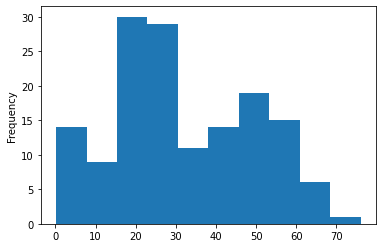

In [26]:
out[out.Survived==1].Age.plot(kind='hist')

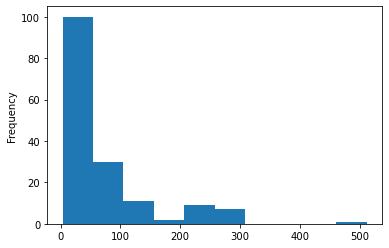

In [27]:
out[out.Survived==1].Fare.plot(kind='hist')

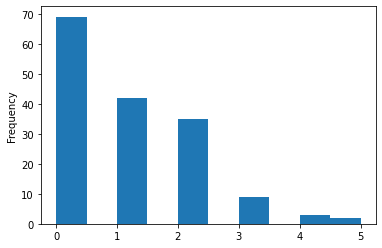

In [28]:
out['Family Size'] = out.Parch + out.SibSp
out[out.Survived==1]['Family Size'].plot(kind='hist')

In [29]:
(out[out.Survived==1]['Family Size'] == 0).sum()

69

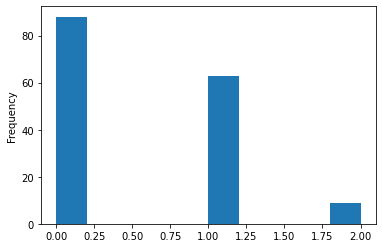

In [30]:
out.Embarked = out.Embarked.apply(lambda x: 0 if x=='S' else (1 if x=='C' else (2 if x=='Q' else print(x))))
out[out.Survived==1].Embarked.plot(kind='hist')

In [31]:
(out[out.Survived==1].Embarked == 0).sum(), (out[out.Survived==1].Embarked == 1).sum(), (out[out.Survived==1].Embarked == 2).sum()

(88, 63, 9)

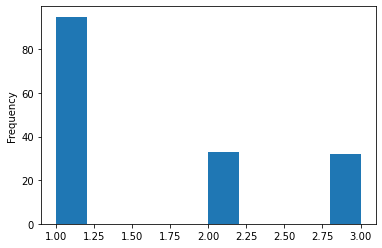

In [32]:
out[out.Survived==1].Pclass.plot(kind='hist')

In [33]:
(out[out.Survived==1].Pclass==3).sum()

32

In [34]:
for i in range(1, 4):
    print(i, (out[out.Survived==1].Pclass==i).sum(), (out.Pclass==i).sum(), (out[out.Survived==1].Pclass==i).sum()/(out.Pclass==i).sum())

1 95 107 0.8878504672897196
2 33 93 0.3548387096774194
3 32 218 0.14678899082568808


In [35]:
for i in range(3):
    print(i, (out[out.Survived==1].Embarked==i).sum(), (out.Embarked==i).sum(), (out[out.Survived==1].Embarked==i).sum()/(out.Embarked==i).sum())

0 88 270 0.32592592592592595
1 63 102 0.6176470588235294
2 9 46 0.1956521739130435


# train a decision tree classifier

In [212]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import tree

In [223]:
clf = DecisionTreeClassifier()

In [224]:
clf_x = train_data.drop(['Survived', 'Name', 'Cabin', "Ticket"], axis=1)
clf_x['Family Size'] = clf_x.SibSp + clf_x.Parch
clf_x = clf_x.drop(['SibSp', 'Parch'], axis=1)
clf_x.Embarked = clf_x.Embarked.apply(lambda x: 0 if x=='S' else (1 if x=='C' else (2 if x=='Q' else 0)))
clf_x.Sex = clf_x.Sex.apply(lambda x: 0 if x=='female' else 1)
clf_x.Age = clf_x.Age.fillna(clf_x.Age.mean())
clf_x.isna().any()

PassengerId    False
Pclass         False
Sex            False
Age            False
Fare           False
Embarked       False
Family Size    False
dtype: bool

In [227]:
clf = clf.fit(X=clf_x, y=train_data.Survived)

In [244]:
clf_test = out.drop(['Survived', 'Name', 'Cabin', "Ticket"], axis=1)
clf_test['Family Size'] = clf_test.SibSp + clf_test.Parch
clf_test = clf_test.drop(['SibSp', 'Parch'], axis=1)
# clf_x.Embarked = clf_x.Embarked.apply(lambda x: 0 if x=='S' else (1 if x=='C' else (2 if x=='Q' else 0)))
clf_test.Sex = clf_test.Sex.apply(lambda x: 0 if x=='female' else 1)
clf_test.Fare = clf_test.Fare.fillna(clf_test.Fare.mean())
clf_test.Age = clf_test.Age.fillna(clf_test.Age.mean())
clf_test.isna().any()

PassengerId    False
Pclass         False
Sex            False
Age            False
Fare           False
Embarked       False
Family Size    False
dtype: bool

In [249]:
out = clf.predict(clf_test)
out

array([0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0.,
       1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0.,
       1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 1., 0., 1., 0.

In [250]:
kaggle_out = pd.read_csv('data/titanic/result-decision-tree.csv')
kaggle_out["Survived"] = pd.Series(out)
kaggle_out.to_csv('data/titanicresult-decision-tree', index=False)